# This notebook compares different types of MCS track statistics between v3 and v2 datasets
## Require data: MCS final track statistics files
- v2: robust_mcs_tracks_*.nc
- v3: mcs_tracks_final_*.nc

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes as crs_geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline

## Specify region of interest, months, land/ocean MCS definition

In [112]:
# Select a region (Amazon, Argentina)
region = 'USA'

# Min number of MCS to plot
min_ntracks = 10

# MCS lifetime limits
lifetime_bounds = [2,60]

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.9
ocean_frac_thresh = 0.1

# Define region bounds
# box_usa = [-110,-70,30,50]
box_usa = [-110,-85,30,49]
# Months to include
# months_usa = [3,4,5,6,7,8,9,10]
months_usa = np.arange(1,13,1)

# Lookup region based on input
bounds_dict = {'USA':box_usa}
months_dict = {'USA':months_usa}
bounds = bounds_dict[region]
months = months_dict[region]
print(f'{region} lat/lon bounds: {bounds}')
print(f'{region} months: {months}')

USA lat/lon bounds: [-110, -85, 30, 49]
USA months: [ 1  2  3  4  5  6  7  8  9 10 11 12]


### Show a map for the subset region

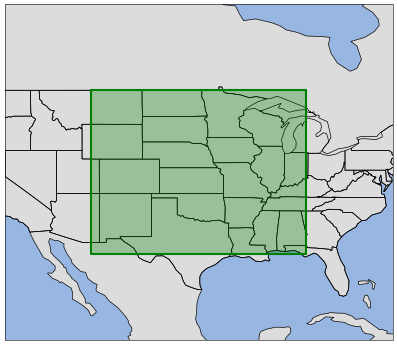

In [113]:
resolution = '110m'
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
ax.add_feature(borders, edgecolor='k', facecolor='none')
ax.add_feature(states, edgecolor='k', facecolor='none')
# Plot a box region in the inset
box = sgeom.box(minx=bounds[0], maxx=bounds[1], miny=bounds[2], maxy=bounds[3])
ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=3)
ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

## Specify input data location

In [114]:
# Specify years to include in the statistics
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

# Sepcify directory of the MCS track stats file
dir_v2 = '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf/'
dir_v3 = '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/'
files_v2 = []
files_v3 = []
for yy in years:
    files_v2 = files_v2 + sorted(glob.glob(f'{dir_v2}/robust/filtered/robust_mcs_tracks_{yy}*.nc'))
    files_v3 = files_v3 + sorted(glob.glob(f'{dir_v3}/mcs_tracks_final_extc_{yy}*.nc'))
nfiles_v2 = len(files_v2)
nfiles_v3 = len(files_v3)
print(f'Number of files (v2): {nfiles_v2}')
print(f'Number of files (v3): {nfiles_v3}')

# Output figure directory
figdir = '/global/cfs/cdirs/m2637/zfeng/gridrad_v3/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (v2): 14
Number of files (v3): 14
/global/cfs/cdirs/m2637/zfeng/gridrad_v3/figures/


In [115]:
files_v2

['/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20040101_20041231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20050101_20051231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20060101_20061231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20070101_20071231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20080101_20081231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20090101_20091231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20100101_20101231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_tracks_20110101_20111231.nc',
 '/global/cfs/cdirs/m2637/zfeng/gridrad_v2/stats_linkpf//robust/filtered/robust_mcs_trac

In [116]:
files_v3

['/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20040101.0000_20050101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20050101.0000_20060101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20060101.0000_20070101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20070101.0000_20080101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20080101.0000_20090101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20090101.0000_20100101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20100101.0000_20110101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20110101.0000_20120101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20120101.0000_20130101.0000.nc',
 '/pscratch/sd/f/feng045/usa/gridrad_v3/stats/mcs_tracks_final_extc_20130101.0000_20140101.

In [117]:
# Read v2 data
dsv2 = xr.open_mfdataset(files_v2, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_v2 = dsv2.sizes['tracks']
dsv2['tracks'] = np.arange(0, ntracks_v2)
# pixel_radius_v2 = dsv2.attrs['pixel_radius_km']
pixel_radius_v2 = 4.0
# dsv2

In [118]:
# Read v3 data
dsv3 = xr.open_mfdataset(files_v3, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_v3 = dsv3.sizes['tracks']
dsv3['tracks'] = np.arange(0, ntracks_v3)
pixel_radius_v3 = dsv3.attrs['pixel_radius_km']
# # Convert longitudes from 0~360 to -180~+180
# dsv3['meanlon'] = ((dsv3.meanlon - 180) % 360) - 180
# dsv3['pf_lon'] = ((dsv3.pf_lon - 180) % 360) - 180
# dsv3['pf_lon_centroid'] = ((dsv3.pf_lon_centroid - 180) % 360) - 180
# dsv3['pf_lon_weightedcentroid'] = ((dsv3.pf_lon_weightedcentroid - 180) % 360) - 180
# dsv3

## Custom functions for track selections

In [119]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds, smonth_vals):
    """
    Find tracks within a region, lifetime, and month bounds.
    """
    # Get the track initiation month and location
    start_month = start_basetime.dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)) & \
        (np.in1d(start_month, smonth_vals))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber.compute())
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber.compute())
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber.compute()) & np.isnan(ds.end_merge_cloudnumber.compute())
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber.compute()) | ~np.isnan(ds.end_merge_cloudnumber.compute())
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

## Subset tracks within a region and months

In [120]:
# Get time resolution of data
time_res_v2 = dsv2.attrs['time_resolution_hour']
time_res_v3 = dsv3.attrs['time_resolution_hour']
# Convert track duration to physical lifetime
lifetime_v2 = dsv2.length * time_res_v2
lifetime_v3 = dsv3.track_duration * time_res_v3

# Subset MCS by region and lifetime
lon_bounds = [bounds[0],bounds[1]]
lat_bounds = [bounds[2],bounds[3]]
# lon_bounds, lat_bounds
start_basetime_v2 = dsv2.base_time.isel(times=0)

mcsidx_v2 = find_track_in_region(start_basetime_v2, dsv2.meanlon, dsv2.meanlat, lifetime_v2, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (v2): {len(mcsidx_v2)}')
mcsidx_v3 = find_track_in_region(dsv3.start_basetime, dsv3.meanlon, dsv3.meanlat, lifetime_v3, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (v3): {len(mcsidx_v3)}')

Number of tracks (v2): 4024
Number of tracks (v3): 3731


(array([ 63.,  82., 177., 313., 533., 667., 643., 591., 310., 182., 170.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 11 artists>)

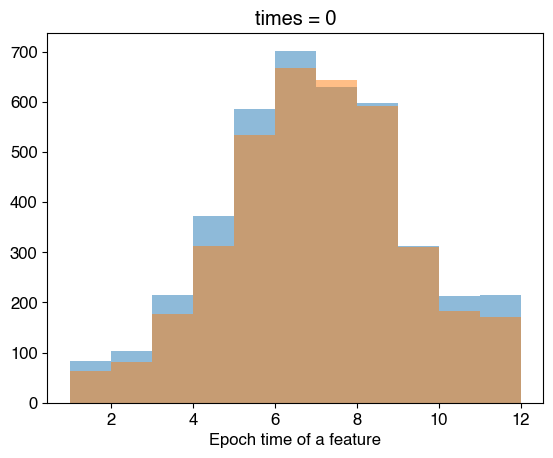

In [121]:
# Check the distribution of tracks by month
dsv2.base_time.dt.month.isel(tracks=mcsidx_v2, times=0).plot.hist(bins=np.arange(1,13,1), alpha=0.5)
dsv3.base_time.dt.month.isel(tracks=mcsidx_v3, times=0).plot.hist(bins=np.arange(1,13,1), alpha=0.5)

## Calculate mean/std of the number of MCSs by month
- Requires at least 3 years of data

In [122]:
# Get start basetime for the tracks
start_basetime_v2 = dsv2.base_time.isel(tracks=mcsidx_v2, times=0).compute()
start_basetime_v3 = dsv3.base_time.isel(tracks=mcsidx_v3, times=0).compute()

nmonths = len(months)
nyears = len(years)
nmcs_month_avg_v2 = np.ndarray(nmonths, dtype=np.float32)
nmcs_month_std_v2 = np.ndarray(nmonths, dtype=np.float32)
nmcs_month_avg_v3 = np.ndarray(nmonths, dtype=np.float32)
nmcs_month_std_v3 = np.ndarray(nmonths, dtype=np.float32)

# Loop over each month
for im in range(0, nmonths):
    # Find startyear with the same months
    syear_v2_tmp = start_basetime_v2.dt.year.where(start_basetime_v2.dt.month == months[im], drop=True)
    syear_v3_tmp = start_basetime_v3.dt.year.where(start_basetime_v3.dt.month == months[im], drop=True)

    # Make a temporary array to count the number
    count_v2 = np.ndarray(nyears, dtype=np.float32)
    count_v3 = np.ndarray(nyears, dtype=np.float32)

    # Loop over each year and save the count
    for iy in range(0, nyears):
        count_v2[iy] = syear_v2_tmp.where(syear_v2_tmp == years[iy], drop=True).count()
        count_v3[iy] = syear_v3_tmp.where(syear_v3_tmp == years[iy], drop=True).count()

    # Calculate average/std of counts for each month
    nmcs_month_avg_v2[im] = np.nanmean(count_v2)
    nmcs_month_std_v2[im] = np.nanstd(count_v2)
    nmcs_month_avg_v3[im] = np.nanmean(count_v3)
    nmcs_month_std_v3[im] = np.nanstd(count_v3)

## MCS Seasonal Cycle Counts

In [123]:
def get_month_names(month_numbers):
    """
    Get month names based on list of month numbers
    """
    month_dict = {
        1: 'Jan',
        2: 'Feb',
        3: 'Mar',
        4: 'Apr',
        5: 'May',
        6: 'Jun',
        7: 'Jul',
        8: 'Aug',
        9: 'Sep',
        10: 'Oct',
        11: 'Nov',
        12: 'Dec'
    }
    month_names = []
    for month_number in month_numbers:
        month_name = month_dict.get(month_number)
        month_names.append(month_name)
    return month_names

/global/cfs/cdirs/m2637/zfeng/gridrad_v3/figures/mcs_number_bymonth_v2_v3.png


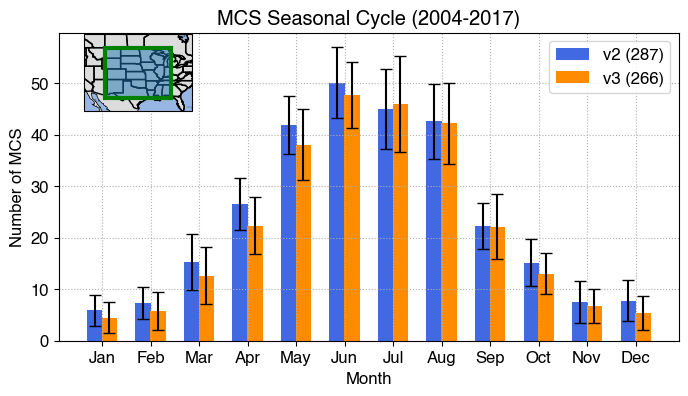

In [124]:
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.weight'] = 'regular'
fig = plt.figure(figsize=[8,4], dpi=100)
ax = plt.subplot()
width = 0.32
ax.bar(np.array(months)-0.15, nmcs_month_avg_v2, width, color='royalblue', yerr=nmcs_month_std_v2, capsize=4, label=f'v2 ({np.sum(nmcs_month_avg_v2):.0f})')
ax.bar(np.array(months)+0.15, nmcs_month_avg_v3, width, color='darkorange', yerr=nmcs_month_std_v3, capsize=4, label=f'v3 ({np.sum(nmcs_month_avg_v3):.0f})')

ax.legend()
ax.set_xlabel('Month', fontweight='regular')
ax.set_ylabel('Number of MCS', fontweight='regular')
ax.set_title(f'MCS Seasonal Cycle ({min(years)}-{max(years)})', fontweight='regular')
ax.grid(True, which='major', ls='dotted')
# ax.set_ylim(0,80)
# ax.set_yticks(np.arange(0,36,5))
ax.set_xticks(months)
ax.set_xticklabels(get_month_names(months))

# Inset map settings
map_extent = [lon_bounds[0]-8,lon_bounds[1]+8,lat_bounds[0]-5,lat_bounds[1]+5]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'25%', 'height':'25%', 'loc':'upper left', 'borderpad':0.1}
map_extent, lonbox, latbox

resolution = '50m'
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                    axes_kwargs=dict(projection=proj))
sub_ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))
sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.5, zorder=9))

figname = f'{figdir}mcs_number_bymonth_v2_v3.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
print(figname)

## Separate land vs. ocean MCS

In [16]:
# # Separate land vs. ocean MCS
# ds_l_obs, ds_o_obs = get_land_ocean_ds(dsv2, mcsidx_obs, land_frac_thresh, ocean_frac_thresh)
# ds_l_obs = dsv2
# print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}")
# #print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}, Number of ocean MCS (OBS): {ds_o_obs.dims['tracks']}")

# # Separate land vs. ocean MCS
# ds_l_m1, ds_o_m1 = get_land_ocean_ds(dsv3, mcsidx_m1, land_frac_thresh, ocean_frac_thresh)
# ds_l_m1 = dsv3
# print(f"Number of land MCS (WRF): {ds_l_m1.dims['tracks']}")
# #print(f"Number of land MCS (WRF): {ds_l_m1.dims['tracks']}, Number of ocean MCS (WRF): {ds_o_m1.dims['tracks']}")

## Subset tracks

In [17]:
dsv2_s = dsv2.isel(tracks=mcsidx_v2)
dsv3_s = dsv3.isel(tracks=mcsidx_v3)
# tid_l_m1 = find_merge_split_tracks(ds)

## Find merge/split track indices

In [18]:
# Non-merge, non-split
idx_ns_v2 = ((dsv2_s.starttrackresult != 13).compute() == True)
idx_nm_v2 = ((dsv2_s.endtrackresult != 12).compute() == True)
# Non-merge & non-split
idx_nms_v2 = (((dsv2_s.starttrackresult != 13) & (dsv2_s.endtrackresult != 12)).compute() == True)

# Group outputs to dictionary
tid_v2 = {
    'nms': idx_nms_v2,
    'nm': idx_nm_v2,
    'ns': idx_ns_v2,
}

In [19]:
# dsv2_s.starttrackresult.isel(tracks=idx_nms_v2).plot.hist(bins=np.arange(0,14,1))

In [20]:
# dsv2_s.endtrackresult.isel(tracks=idx_nm_v2).plot.hist(bins=np.arange(0,14,1))

In [21]:
idx_nms_v2

<xarray.DataArray (tracks: 3624)> Size: 4kB
array([ True,  True, False, ...,  True, False, False])
Coordinates:
  * tracks   (tracks) int64 29kB 26 27 29 30 31 32 ... 6309 6310 6314 6315 6317

In [22]:
tid_v3 = find_merge_split_tracks(dsv3_s)

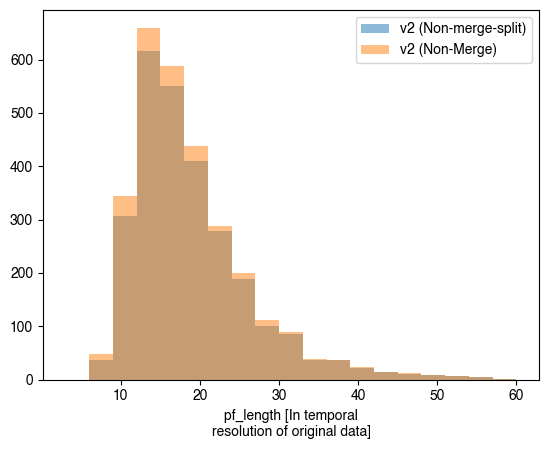

In [23]:
bins = np.arange(3,60.1,3)
dsv2_s.isel(tracks=tid_v2['nms']).pf_length.plot.hist(bins=bins, alpha=0.5, label='v2 (Non-merge-split)')
dsv2_s.isel(tracks=tid_v2['nm']).pf_length.plot.hist(bins=bins, alpha=0.5, label='v2 (Non-Merge)')
plt.legend()

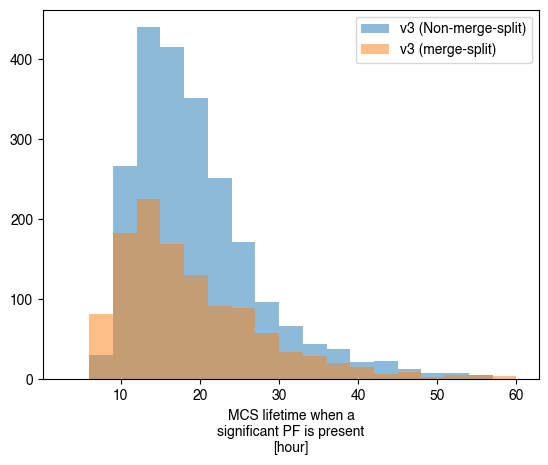

In [24]:
bins = np.arange(3,60.1,3)
dsv3_s.isel(tracks=tid_v3['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='v3 (Non-merge-split)')
dsv3_s.isel(tracks=tid_v3['ms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='v3 (merge-split)')
plt.legend()

In [25]:
dsv3_s.where(dsv3_s.start_basetime.dt.season.compute() == 'JJA', drop=True)

<xarray.Dataset> Size: 3GB
Dimensions:                      (tracks: 1901, times: 300, mergers: 200,
                                  nmaxpf: 5, lifestages: 5)
Coordinates:
  * tracks                       (tracks) int64 15kB 114 115 117 ... 5638 5645
  * times                        (times) int64 2kB 0 1 2 3 4 ... 296 297 298 299
  * mergers                      (mergers) int64 2kB 0 1 2 3 ... 196 197 198 199
  * nmaxpf                       (nmaxpf) int64 40B 0 1 2 3 4
  * lifestages                   (lifestages) int64 40B 0 1 2 3 4
Data variables: (12/100)
    track_duration               (tracks) float64 15kB dask.array<chunksize=(159,), meta=np.ndarray>
    start_status                 (tracks) float64 15kB dask.array<chunksize=(159,), meta=np.ndarray>
    end_status                   (tracks) float64 15kB dask.array<chunksize=(159,), meta=np.ndarray>
    start_basetime               (tracks) datetime64[ns] 15kB dask.array<chunksize=(159,), meta=np.ndarray>
    end_basetime                 (tracks) datetime64[ns] 15kB dask.array<chunksize=(159,), meta=np.ndarray>
    start_split_cloudnumber      (tracks) float64 15kB dask.array<chunksize=(159,), meta=np.ndarray>
    ...                           ...
    lifecycle_index              (tracks, lifestages) float64 76kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    movement_distance            (tracks, times) float32 2MB dask.array<chunksize=(1, 300), meta=np.ndarray>
    movement_speed               (tracks, times) float32 2MB dask.array<chunksize=(1, 300), meta=np.ndarray>
    movement_theta               (tracks, times) float32 2MB dask.array<chunksize=(1, 300), meta=np.ndarray>
    movement_distance_x          (tracks, times) float32 2MB dask.array<chunksize=(1, 300), meta=np.ndarray>
    movement_distance_y          (tracks, times) float32 2MB dask.array<chunksize=(1, 300), meta=np.ndarray>
Attributes: (12/19)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon Feb 20 14:18:53 2023
    startdate:                   20040101.0000
    enddate:                     20050101.0000
    ...                          ...
    heavy_rainrate_thresh:       10.0
    landfrac_thresh:             90
    MCS_PF_majoraxis_thresh:     100
    MCS_PF_duration_thresh:      5
    PF_PF_min_majoraxis_thresh:  20
    max_speed_thresh:            50

## Subset merge/split tracks

In [26]:
ds_nms_v2 = dsv2_s.isel(tracks=tid_v2['nms'])
print(f"Number of non-merge-split tracks v2: {ds_nms_v2.sizes['tracks']}")

Number of non-merge-split tracks v2: 2710


In [27]:
ds_nms_v3 = dsv3_s.isel(tracks=tid_v3['nms'])
print(f"Number of non-merge-split tracks v3: {ds_nms_v3.sizes['tracks']}")

Number of non-merge-split tracks v3: 2253


In [28]:
# #ds_nms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['nms'])
# ds_nms_v3 = ds_l_m1.isel(tracks=tid_l_m1['nms'])
# #ds_ms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['ms'])
# ds_ms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['ms'])
# print(f"Number of non-merge-split tracks WRF (Land): {ds_nms_v3.dims['tracks']}")
# #print(f"Number of non-merge-split tracks WRF (Ocean): {ds_nms_o_m1.dims['tracks']}")
# print(f"Number of merge-split tracks WRF (Land): {ds_ms_l_m1.dims['tracks']}")
# #print(f"Number of merge-split tracks WRF (Ocean): {ds_ms_o_m1.dims['tracks']}")

## Function to compute 1D KDE

In [29]:
def get_kde1d(data, bins, kde_bw, kde_kernel='gaussian'):
    """
    Compute 1D KDE using Ski-learn
    
    Args:
        data: np.array
            Array containing data.
        bins: np.array
            Desired bins for plotting.
        kde_bw: float
            The bandwidth of the kernel.
        kde_kernel: string
            The kernel to use.
            
    Return:
        kde_out: np.array
            KDE at the desired bins.
    """
    # Flatten array to 1D
    data1d = data.flatten()
    # Remove NaN (sklearn KDE does not handle NaN), and make a new axis
    _data = data1d[~np.isnan(data1d)][:, np.newaxis]
    _bins = bins[:, np.newaxis]
    
    # Estimate 1D KDE following sklearn example
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    kde = KernelDensity(kernel=kde_kernel, bandwidth=kde_bw).fit(_data)
    # Get KDE values based on input bins
    log_dens = kde.score_samples(_bins)
    # Get linear density
    kde_out = np.exp(log_dens)
    return kde_out

In [30]:
# Get track start season (e.g., MAM, JJA, SON, DJF)
start_season_v2 = ds_nms_v2.base_time.isel(times=0).dt.season.compute()
start_season_v3 = ds_nms_v3.start_basetime.dt.season.compute()

### CCS Lifetime

In [31]:
lifetime_bins = np.linspace(0, 60, 1000)
# Get CCS lifetime by season
ccslifetime_nms_v2_MAM = (ds_nms_v2.length.where(start_season_v2 == 'MAM', drop=True) * time_res_v2).compute()
ccslifetime_nms_v3_MAM = (ds_nms_v3.track_duration.where(start_season_v3 == 'MAM', drop=True) * time_res_v3).compute()
ccslifetime_nms_v2_JJA = (ds_nms_v2.length.where(start_season_v2 == 'JJA', drop=True) * time_res_v2).compute()
ccslifetime_nms_v3_JJA = (ds_nms_v3.track_duration.where(start_season_v3 == 'JJA', drop=True) * time_res_v3).compute()
# By season
kde_ccslifetime_nms_v2_MAM = get_kde1d(ccslifetime_nms_v2_MAM.data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_v3_MAM = get_kde1d(ccslifetime_nms_v3_MAM.data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_v2_JJA = get_kde1d(ccslifetime_nms_v2_JJA.data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_v3_JJA = get_kde1d(ccslifetime_nms_v3_JJA.data, lifetime_bins, kde_bw=3)

# All season
kde_ccslifetime_nms_v2 = get_kde1d((ds_nms_v2.length * time_res_v2).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_v3 = get_kde1d((ds_nms_v3.track_duration * time_res_v3).data, lifetime_bins, kde_bw=3)

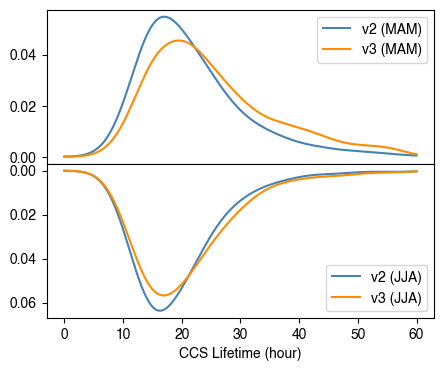

In [32]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_ccslifetime_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(lifetime_bins, kde_ccslifetime_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(lifetime_bins, kde_ccslifetime_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(lifetime_bins, kde_ccslifetime_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('CCS Lifetime (hour)')
fig.subplots_adjust(hspace=0)

### PF Lifetime

In [33]:
# Get PF lifetime by season
pflifetime_nms_v2_MAM = (ds_nms_v2.pf_length.where(start_season_v2 == 'MAM', drop=True)).compute()
pflifetime_nms_v3_MAM = (ds_nms_v3.pf_lifetime.where(start_season_v3 == 'MAM', drop=True)).compute()
pflifetime_nms_v2_JJA = (ds_nms_v2.pf_length.where(start_season_v2 == 'JJA', drop=True)).compute()
pflifetime_nms_v3_JJA = (ds_nms_v3.pf_lifetime.where(start_season_v3 == 'JJA', drop=True)).compute()
# By season
kde_pflifetime_nms_v2_MAM = get_kde1d(pflifetime_nms_v2_MAM.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_v3_MAM = get_kde1d(pflifetime_nms_v3_MAM.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_v2_JJA = get_kde1d(pflifetime_nms_v2_JJA.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_v3_JJA = get_kde1d(pflifetime_nms_v3_JJA.data, lifetime_bins, kde_bw=3)

# All season
kde_pflifetime_nms_v2 = get_kde1d(ds_nms_v2.pf_length.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_v3 = get_kde1d(ds_nms_v3.pf_lifetime.data, lifetime_bins, kde_bw=3)

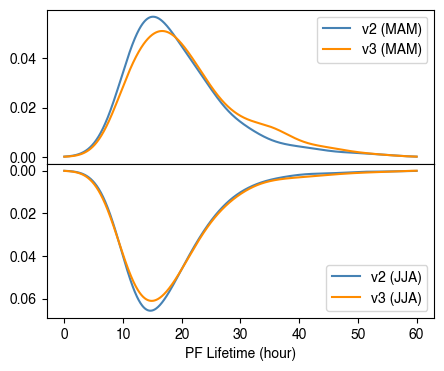

In [34]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_pflifetime_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(lifetime_bins, kde_pflifetime_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(lifetime_bins, kde_pflifetime_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(lifetime_bins, kde_pflifetime_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('PF Lifetime (hour)')
fig.subplots_adjust(hspace=0)

### Max CCS Area

In [35]:
ccsarea_bins = np.linspace(4, 6.8, 1000)
# Add mergers/splits to get total CCS area
# ccsarea_v2 = ds_nms_v2.ccs_area + ds_nms_v2.merge_ccs_area.sum(dim='mergers') + ds_nms_v2.split_ccs_area.sum(dim='mergers')
ccsarea_v2 = ds_nms_v2.ccs_area.compute()
maxccsarea_v2 = ccsarea_v2.max(dim='times')
# ccsarea_v3 = ds_nms_v3.ccs_area + ds_nms_v3.merge_ccs_area.sum(dim='mergers') + ds_nms_v3.split_ccs_area.sum(dim='mergers')
ccsarea_v3 = ds_nms_v3.ccs_area.compute()
maxccsarea_v3 = ccsarea_v3.max(dim='times')
# By season
maxccsarea_v2_MAM = maxccsarea_v2.where(start_season_v2 == 'MAM', drop=True)
maxccsarea_v3_MAM = maxccsarea_v3.where(start_season_v3 == 'MAM', drop=True)
maxccsarea_v2_JJA = maxccsarea_v2.where(start_season_v2 == 'JJA', drop=True)
maxccsarea_v3_JJA = maxccsarea_v3.where(start_season_v3 == 'JJA', drop=True)

kde_maxccsarea_nms_v2_MAM = get_kde1d(np.log10(maxccsarea_v2_MAM.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_v3_MAM = get_kde1d(np.log10(maxccsarea_v3_MAM.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_v2_JJA = get_kde1d(np.log10(maxccsarea_v2_JJA.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_v3_JJA = get_kde1d(np.log10(maxccsarea_v3_JJA.data), ccsarea_bins, kde_bw=0.2)

# All season
kde_maxccsarea_nms_v2 = get_kde1d(np.log10(maxccsarea_v2.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_v3 = get_kde1d(np.log10(maxccsarea_v3.data), ccsarea_bins, kde_bw=0.2)

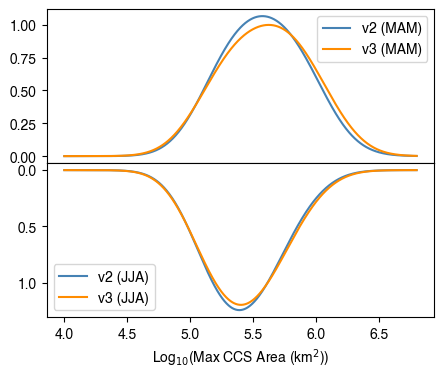

In [36]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(ccsarea_bins, kde_maxccsarea_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(ccsarea_bins, kde_maxccsarea_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max CCS Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Lifetime-average min Tb

In [37]:
# avgmintb_bins = np.linspace(200, 240, 1000)
# # By season
# kde_avgmintb_nms_l_obs_MAM = get_kde1d(ds_nms_v2.corecold_mintb.where(start_season_obs == 'MAM', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)
# kde_avgmintb_nms_l_m1_MAM = get_kde1d(ds_nms_v3.corecold_mintb.where(start_season_m1 == 'MAM', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)
# kde_avgmintb_nms_l_obs_JJA = get_kde1d(ds_nms_v2.corecold_mintb.where(start_season_obs == 'JJA', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)
# kde_avgmintb_nms_l_m1_JJA = get_kde1d(ds_nms_v3.corecold_mintb.where(start_season_m1 == 'JJA', drop=True).mean(dim='times').data, avgmintb_bins, kde_bw=2)

# # Land
# kde_avgmintb_nms_l_obs = get_kde1d(ds_nms_v2.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
# kde_avgmintb_nms_l_m1 = get_kde1d(ds_nms_v3.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)

In [38]:
# fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
# ax = axes[0]
# ax.plot(avgmintb_bins, kde_avgmintb_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
# ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
# ax.legend()
# ax = axes[1]
# ax.plot(avgmintb_bins, kde_avgmintb_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
# ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
# ax.invert_yaxis()
# ax.legend()
# ax.set_xlabel('Lifetime-Mean Min Tb (K)')
# fig.subplots_adjust(hspace=0)

### Lifetime-min Min Tb

In [39]:
# mintb_bins = np.linspace(190, 230, 1000)
# # By season
# kde_mintb_nms_l_obs_MAM = get_kde1d(ds_nms_v2.corecold_mintb.where(start_season_obs == 'MAM', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)
# kde_mintb_nms_l_m1_MAM = get_kde1d(ds_nms_v3.corecold_mintb.where(start_season_m1 == 'MAM', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)
# kde_mintb_nms_l_obs_JJA = get_kde1d(ds_nms_v2.corecold_mintb.where(start_season_obs == 'JJA', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)
# kde_mintb_nms_l_m1_JJA = get_kde1d(ds_nms_v3.corecold_mintb.where(start_season_m1 == 'JJA', drop=True).min(dim='times').data, mintb_bins, kde_bw=2)

# # All seasons
# kde_mintb_nms_l_obs = get_kde1d(ds_nms_v2.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
# kde_mintb_nms_l_m1 = get_kde1d(ds_nms_v3.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)

In [40]:
# fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
# ax = axes[0]
# ax.plot(mintb_bins, kde_mintb_nms_l_obs_MAM, 'steelblue', label='OBS (MAM)')
# ax.plot(mintb_bins, kde_mintb_nms_l_m1_MAM, 'darkorange', label='WRF (MAM)')
# ax.legend()
# ax = axes[1]
# ax.plot(mintb_bins, kde_mintb_nms_l_obs_JJA, 'steelblue', label='OBS (JJA)')
# ax.plot(mintb_bins, kde_mintb_nms_l_m1_JJA, 'darkorange', label='WRF (JJA)')
# ax.invert_yaxis()
# ax.legend()
# ax.set_xlabel('Lifetime-Min Min Tb (K)')
# fig.subplots_adjust(hspace=0)

### Max PF Area

In [41]:
pfarea_bins = np.linspace(3.3, 6.5, 1000)
# Sum all PFs at a given time, then take max during lifetime
# maxpfarea_v2 = ds_nms_v2.pf_area.sum(dim='nmaxpf').max(dim='times')
# maxpfarea_v3 = ds_nms_v3.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_v2 = ds_nms_v2.pf_area.max(dim='nmaxpf').max(dim='times').compute()
maxpfarea_v3 = ds_nms_v3.pf_area.max(dim='nmaxpf').max(dim='times').compute()
# By season
kde_maxpfarea_nms_v2_MAM = get_kde1d(np.log10(maxpfarea_v2.where(start_season_v2 == 'MAM', drop=True).data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_v3_MAM = get_kde1d(np.log10(maxpfarea_v3.where(start_season_v2 == 'MAM', drop=True).data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_v2_JJA = get_kde1d(np.log10(maxpfarea_v2.where(start_season_v3 == 'JJA', drop=True).data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_v3_JJA = get_kde1d(np.log10(maxpfarea_v3.where(start_season_v3 == 'JJA', drop=True).data), pfarea_bins, kde_bw=0.2)

# All seasons
kde_maxpfarea_nms_v2 = get_kde1d(np.log10(maxpfarea_v2.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_v3 = get_kde1d(np.log10(maxpfarea_v3.data), pfarea_bins, kde_bw=0.2)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


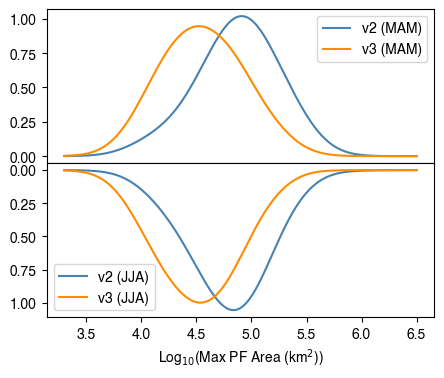

In [42]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfarea_bins, kde_maxpfarea_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(pfarea_bins, kde_maxpfarea_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfarea_bins, kde_maxpfarea_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(pfarea_bins, kde_maxpfarea_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max PF Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Mean PF Rain Rate

In [43]:
pfrainrate_bins = np.linspace(0., 15, 1000)
# Select the largest PF (nmaxpf=0), then take mean during lifetime
meanpfrainrate_v2 = ds_nms_v2.pf_rainrate.isel(nmaxpf=0).mean(dim='times').compute()
meanpfrainrate_v3 = ds_nms_v3.pf_rainrate.isel(nmaxpf=0).mean(dim='times').compute()
# By season
kde_meanpfrainrate_nms_v2_MAM = get_kde1d(meanpfrainrate_v2.where(start_season_v2 == 'MAM', drop=True).data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_v3_MAM = get_kde1d(meanpfrainrate_v3.where(start_season_v3 == 'MAM', drop=True).data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_v2_JJA = get_kde1d(meanpfrainrate_v2.where(start_season_v2 == 'JJA', drop=True).data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_v3_JJA = get_kde1d(meanpfrainrate_v3.where(start_season_v3 == 'JJA', drop=True).data, pfrainrate_bins, kde_bw=0.5)

# Land
kde_meanpfrainrate_nms_v2 = get_kde1d(meanpfrainrate_v2.data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_v3 = get_kde1d(meanpfrainrate_v3.data, pfrainrate_bins, kde_bw=0.5)

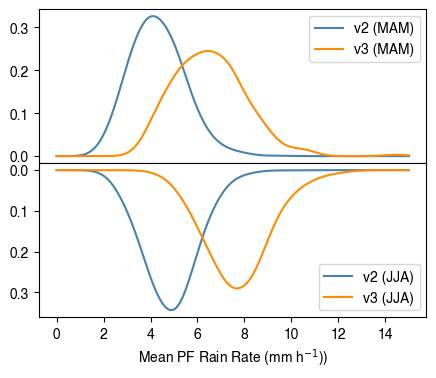

In [44]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Mean PF Rain Rate (mm h$^{-1}$))')
fig.subplots_adjust(hspace=0)

### Convective core major axis length

In [45]:
maxcoremajoraxis_v2 = ds_nms_v2.pf_coremajoraxislength.max(dim=('nmaxcore','times')).compute()
maxcoremajoraxis_v3 = ds_nms_v3.pf_coremajoraxis.max(dim=('nmaxpf','times')).compute()

coremajoraxis_bins = np.linspace(0, 700, 1000)
# By season
kde_maxcoremajoraxis_nms_v2_MAM = get_kde1d(maxcoremajoraxis_v2.where(start_season_v2 == 'MAM', drop=True).data, coremajoraxis_bins, kde_bw=30)
kde_maxcoremajoraxis_nms_v3_MAM = get_kde1d(maxcoremajoraxis_v3.where(start_season_v3 == 'MAM', drop=True).data, coremajoraxis_bins, kde_bw=30)
kde_maxcoremajoraxis_nms_v2_JJA = get_kde1d(maxcoremajoraxis_v2.where(start_season_v2 == 'JJA', drop=True).data, coremajoraxis_bins, kde_bw=30)
kde_maxcoremajoraxis_nms_v3_JJA = get_kde1d(maxcoremajoraxis_v3.where(start_season_v3 == 'JJA', drop=True).data, coremajoraxis_bins, kde_bw=30)

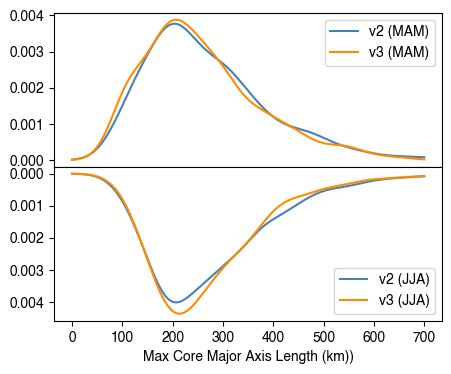

In [46]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(coremajoraxis_bins, kde_maxcoremajoraxis_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(coremajoraxis_bins, kde_maxcoremajoraxis_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(coremajoraxis_bins, kde_maxcoremajoraxis_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(coremajoraxis_bins, kde_maxcoremajoraxis_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Max Core Major Axis Length (km))')
fig.subplots_adjust(hspace=0)

### Lifetime-max convective core ETH

In [47]:
maxcoreETH30dbz_v2 = ds_nms_v2.pf_coremaxdbz30.max(dim=('nmaxcore','times')).compute()
maxcoreETH30dbz_v3 = ds_nms_v3.pf_coremaxechotop30.max(dim=('nmaxpf','times')).compute()

coreETH30dbz_bins = np.linspace(3, 22, 1000)
# By season
kde_maxETH30dbz_nms_v2_MAM = get_kde1d(maxcoreETH30dbz_v2.where(start_season_v2 == 'MAM', drop=True).data, coreETH30dbz_bins, kde_bw=1)
kde_maxETH30dbz_nms_v3_MAM = get_kde1d(maxcoreETH30dbz_v3.where(start_season_v3 == 'MAM', drop=True).data, coreETH30dbz_bins, kde_bw=1)
kde_maxETH30dbz_nms_v2_JJA = get_kde1d(maxcoreETH30dbz_v2.where(start_season_v2 == 'JJA', drop=True).data, coreETH30dbz_bins, kde_bw=1)
kde_maxETH30dbz_nms_v3_JJA = get_kde1d(maxcoreETH30dbz_v3.where(start_season_v3 == 'JJA', drop=True).data, coreETH30dbz_bins, kde_bw=1)

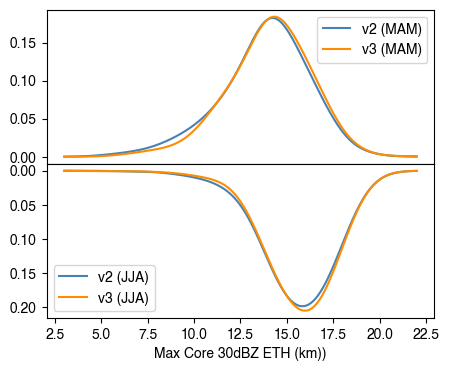

In [48]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(coreETH30dbz_bins, kde_maxETH30dbz_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(coreETH30dbz_bins, kde_maxETH30dbz_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(coreETH30dbz_bins, kde_maxETH30dbz_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(coreETH30dbz_bins, kde_maxETH30dbz_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Max Core 30dBZ ETH (km))')
fig.subplots_adjust(hspace=0)

### Lifetime-max convective core 45dBZ area

In [49]:
max45dbzarea_v2 = ds_nms_v2.pf_dbz45area.max(dim=('nmaxpf','times')).compute()
max45dbzarea_v3 = ds_nms_v3.pf_cc45area.max(dim=('nmaxpf','times')).compute()

core45dbzarea_bins = np.linspace(0.2, 2, 1000)

# By season
kde_max45dbzarea_nms_v2_MAM = get_kde1d(np.log10(maxcoreETH30dbz_v2.where(start_season_v2 == 'MAM', drop=True).data), core45dbzarea_bins, kde_bw=0.2)
kde_max45dbzarea_nms_v3_MAM = get_kde1d(np.log10(maxcoreETH30dbz_v3.where(start_season_v3 == 'MAM', drop=True).data), core45dbzarea_bins, kde_bw=0.2)

kde_max45dbzarea_nms_v2_JJA = get_kde1d(np.log10(maxcoreETH30dbz_v2.where(start_season_v2 == 'JJA', drop=True).data), core45dbzarea_bins, kde_bw=0.2)
kde_max45dbzarea_nms_v3_JJA = get_kde1d(np.log10(maxcoreETH30dbz_v3.where(start_season_v3 == 'JJA', drop=True).data), core45dbzarea_bins, kde_bw=0.2)

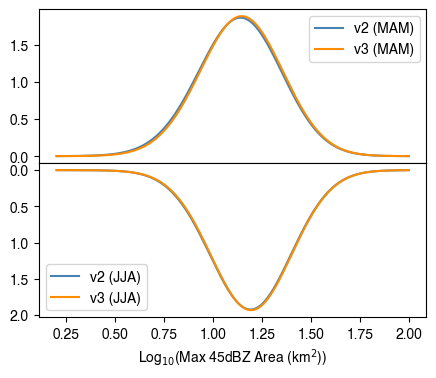

In [50]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(core45dbzarea_bins, kde_max45dbzarea_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(core45dbzarea_bins, kde_max45dbzarea_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(core45dbzarea_bins, kde_max45dbzarea_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(core45dbzarea_bins, kde_max45dbzarea_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max 45dBZ Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Lifetime-mean convective rain amount

In [51]:
meanconvrain_v2 = ds_nms_v2.pf_ccvolrate.mean(dim='times').compute()
meanconvrain_v3 = ds_nms_v3.conv_rain.mean(dim='times').compute()

convrain_bins = np.linspace(1.5, 5, 1000)
# By season
kde_meanconvrain_nms_v2_MAM = get_kde1d(np.log10(meanconvrain_v2.where(start_season_v2 == 'MAM', drop=True).data), convrain_bins, kde_bw=0.2)
kde_meanconvrain_nms_v3_MAM = get_kde1d(np.log10(meanconvrain_v3.where(start_season_v3 == 'MAM', drop=True).data), convrain_bins, kde_bw=0.2)
kde_meanconvrain_nms_v2_JJA = get_kde1d(np.log10(meanconvrain_v2.where(start_season_v2 == 'JJA', drop=True).data), convrain_bins, kde_bw=0.2)
kde_meanconvrain_nms_v3_JJA = get_kde1d(np.log10(meanconvrain_v3.where(start_season_v3 == 'JJA', drop=True).data), convrain_bins, kde_bw=0.2)

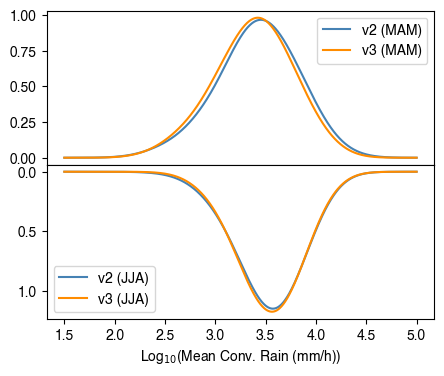

In [52]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(convrain_bins, kde_meanconvrain_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(convrain_bins, kde_meanconvrain_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(convrain_bins, kde_meanconvrain_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(convrain_bins, kde_meanconvrain_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Mean Conv. Rain (mm/h))')
fig.subplots_adjust(hspace=0)

### Lifetime-mean stratiform rain amount

In [53]:
meanstratrain_v2 = ds_nms_v2.pf_sfvolrate.mean(dim='times').compute()
meanstratrain_v3 = ds_nms_v3.strat_rain.mean(dim='times').compute()

stratrain_bins = np.linspace(1.5, 5.5, 1000)
# By season
kde_meanstratrain_nms_v2_MAM = get_kde1d(np.log10(meanstratrain_v2.where(start_season_v2 == 'MAM', drop=True).data), stratrain_bins, kde_bw=0.2)
kde_meanstratrain_nms_v3_MAM = get_kde1d(np.log10(meanstratrain_v3.where(start_season_v3 == 'MAM', drop=True).data), stratrain_bins, kde_bw=0.2)
kde_meanstratrain_nms_v2_JJA = get_kde1d(np.log10(meanstratrain_v2.where(start_season_v2 == 'JJA', drop=True).data), stratrain_bins, kde_bw=0.2)
kde_meanstratrain_nms_v3_JJA = get_kde1d(np.log10(meanstratrain_v3.where(start_season_v3 == 'JJA', drop=True).data), stratrain_bins, kde_bw=0.2)

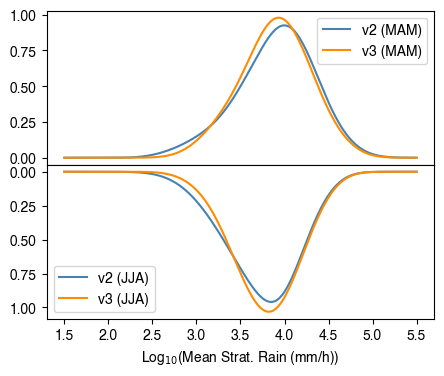

In [54]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(stratrain_bins, kde_meanstratrain_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(stratrain_bins, kde_meanstratrain_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(stratrain_bins, kde_meanstratrain_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(stratrain_bins, kde_meanstratrain_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Mean Strat. Rain (mm/h))')
fig.subplots_adjust(hspace=0)

### Lifetime-median Movement speed

In [55]:
medianspeed_v2 = ds_nms_v2.movement_r_meters_per_second.median(dim='times').compute()
medianspeed_v3 = ds_nms_v3.movement_speed.median(dim='times').compute()

# medianspeed_v2.plot.hist()
pfspeed_bins = np.linspace(0, 45, 1000)
# By season
kde_pfspeed_nms_v2_MAM = get_kde1d(medianspeed_v2.where(start_season_v2 == 'MAM', drop=True).data, pfspeed_bins, kde_bw=3)
kde_pfspeed_nms_v3_MAM = get_kde1d(medianspeed_v3.where(start_season_v3 == 'MAM', drop=True).data, pfspeed_bins, kde_bw=3)

kde_pfspeed_nms_v2_JJA = get_kde1d(medianspeed_v2.where(start_season_v2 == 'JJA', drop=True).data, pfspeed_bins, kde_bw=3)
kde_pfspeed_nms_v3_JJA = get_kde1d(medianspeed_v3.where(start_season_v3 == 'JJA', drop=True).data, pfspeed_bins, kde_bw=3)

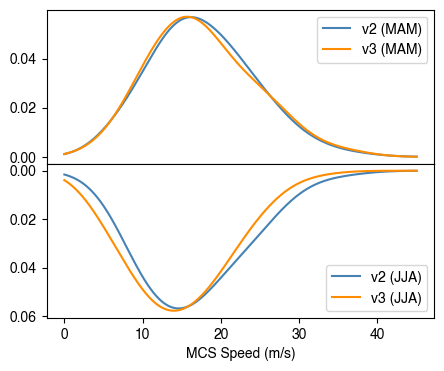

In [56]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfspeed_bins, kde_pfspeed_nms_v2_MAM, 'steelblue', label='v2 (MAM)')
ax.plot(pfspeed_bins, kde_pfspeed_nms_v3_MAM, 'darkorange', label='v3 (MAM)')
ax.legend()
ax = axes[1]
ax.plot(pfspeed_bins, kde_pfspeed_nms_v2_JJA, 'steelblue', label='v2 (JJA)')
ax.plot(pfspeed_bins, kde_pfspeed_nms_v3_JJA, 'darkorange', label='v3 (JJA)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('MCS Speed (m/s)')
fig.subplots_adjust(hspace=0)

## Put variables into dictionary for plotting

In [57]:
# MAM variables
ccslifetime_dict_MAM = {
    'v2': kde_ccslifetime_nms_v2_MAM,
    'v3': kde_ccslifetime_nms_v3_MAM,
}
pfspeed_dict_MAM = {
    'v2': kde_pfspeed_nms_v2_MAM,
    'v3': kde_pfspeed_nms_v3_MAM,
}
ccsarea_dict_MAM = {
    'v2': kde_maxccsarea_nms_v2_MAM,
    'v3': kde_maxccsarea_nms_v3_MAM,
}
pfarea_dict_MAM = {
    'v2': kde_maxpfarea_nms_v2_MAM,
    'v3': kde_maxpfarea_nms_v3_MAM,
}
pfrainrate_dict_MAM = {
    'v2': kde_meanpfrainrate_nms_v2_MAM,
    'v3': kde_meanpfrainrate_nms_v3_MAM,
}
meanstratrain_dict_MAM = {
    'v2': kde_meanstratrain_nms_v2_MAM,
    'v3': kde_meanstratrain_nms_v3_MAM,
}
meanconvrain_dict_MAM = {
    'v2': kde_meanconvrain_nms_v2_MAM,
    'v3': kde_meanconvrain_nms_v3_MAM,
}
max45dbzarea_dict_MAM = {
    'v2': kde_max45dbzarea_nms_v2_MAM,
    'v3': kde_max45dbzarea_nms_v3_MAM,
}
maxcoremaxis_dict_MAM = {
    'v2': kde_maxcoremajoraxis_nms_v2_MAM,
    'v3': kde_maxcoremajoraxis_nms_v3_MAM,
}
maxETH30dbz_dict_MAM = {
    'v2': kde_maxETH30dbz_nms_v2_MAM,
    'v3': kde_maxETH30dbz_nms_v3_MAM,
}

# JJA variables
ccslifetime_dict_JJA = {
    'v2': kde_ccslifetime_nms_v2_JJA,
    'v3': kde_ccslifetime_nms_v3_JJA,
}
pfspeed_dict_JJA = {
    'v2': kde_pfspeed_nms_v2_JJA,
    'v3': kde_pfspeed_nms_v3_JJA,
}
ccsarea_dict_JJA = {
    'v2': kde_maxccsarea_nms_v2_JJA,
    'v3': kde_maxccsarea_nms_v3_JJA,
}
pfarea_dict_JJA = {
    'v2': kde_maxpfarea_nms_v2_JJA,
    'v3': kde_maxpfarea_nms_v3_JJA,
}
pfrainrate_dict_JJA = {
    'v2': kde_meanpfrainrate_nms_v2_JJA,
    'v3': kde_meanpfrainrate_nms_v3_JJA,
}
meanstratrain_dict_JJA = {
    'v2': kde_meanstratrain_nms_v2_JJA,
    'v3': kde_meanstratrain_nms_v3_JJA,
}
meanconvrain_dict_JJA = {
    'v2': kde_meanconvrain_nms_v2_JJA,
    'v3': kde_meanconvrain_nms_v3_JJA,
}
max45dbzarea_dict_JJA = {
    'v2': kde_max45dbzarea_nms_v2_JJA,
    'v3': kde_max45dbzarea_nms_v3_JJA,
}
maxcoremaxis_dict_JJA = {
    'v2': kde_maxcoremajoraxis_nms_v2_JJA,
    'v3': kde_maxcoremajoraxis_nms_v3_JJA,
}
maxETH30dbz_dict_JJA = {
    'v2': kde_maxETH30dbz_nms_v2_JJA,
    'v3': kde_maxETH30dbz_nms_v3_JJA,
}

## Function to plot mirror 1D KDE on (m row x n column) panels

In [58]:
def plot_pdf_mirror_mxn(nrow, ncol, nrowsub, ncolsub, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,  
                fontsize=None, map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=None,
                xscale=None, yscale=None, xlims=None, ylims=None, label_topbot=None, label_pos=None,
                legend_fontsize=11, legend_loc=None, legend_ncol=None, figsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    
    lw = 3
    lcolors = {
        'v2':'steelblue', 
        'v3': 'darkorange',
    }
    
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.3)

    for row in range(nrow):
        for col in range(ncol):
            # gridspec inside gridspec
            inner_grid = outer_grid[row, col].subgridspec(nrowsub, ncolsub, wspace=0, hspace=0)
            axs = inner_grid.subplots()
            ax1 = axs[0]  # top
            ax2 = axs[1]  # bottom
            ax2.invert_yaxis()
            # Top panel
            ax1.plot(bins[row][col], data_top[row][col]['v2'], lcolors['v2'], lw=lw, label=legends['v2'])
            ax1.plot(bins[row][col], data_top[row][col]['v3'], lcolors['v3'], lw=lw, label=legends['v3'])
            # Bottom panel
            ax2.plot(bins[row][col], data_bot[row][col]['v2'], lcolors['v2'], lw=lw, label=legends['v2'])
            ax2.plot(bins[row][col], data_bot[row][col]['v3'], lcolors['v3'], lw=lw, label=legends['v3'])
            # Labels, gridlines, etc.
            ax1.grid(which='major', ls='--')
            ax2.grid(which='major', ls='--')
            ax1.set_title(titles[row][col], loc='left')
            ax2.set_xlabel(xlabels[row][col])
            # Hide x axis label marks
            ax1.tick_params(labelbottom=False) 
            # Label top/bottom panels
            ax1.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['top'], ha='left', transform=ax1.transAxes)
            ax2.text(label_pos['bottom']['x'], label_pos['bottom']['y'], label_topbot['bottom'], ha='left', transform=ax2.transAxes)
            # Label yaxis, legend
            if (col == 0):
                ax1.legend(fontsize=legend_fontsize, loc=legend_loc[0], ncol=legend_ncol[0])
                ax1.text(-0.25, 1, ylabels[row][col], va='center', ha='center', rotation=90, transform=ax2.transAxes)           
            
            # Plot inset map
            if (row == map_panel['row']) & (col == map_panel['col']) & (map_panel['rowsub'] == 0) & (map_panel['colsub'] == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax1, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

## Setup legend, inset map

In [103]:
legends = {
    'v2': 'v2',
    'v3': 'v3',
}
# Inset map settings
map_extent = [lon_bounds[0]-5,lon_bounds[1]+5,lat_bounds[0]-3,lat_bounds[1]+3]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'40%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-115, -80, 27, 52], [-110, -86], [30, 49])

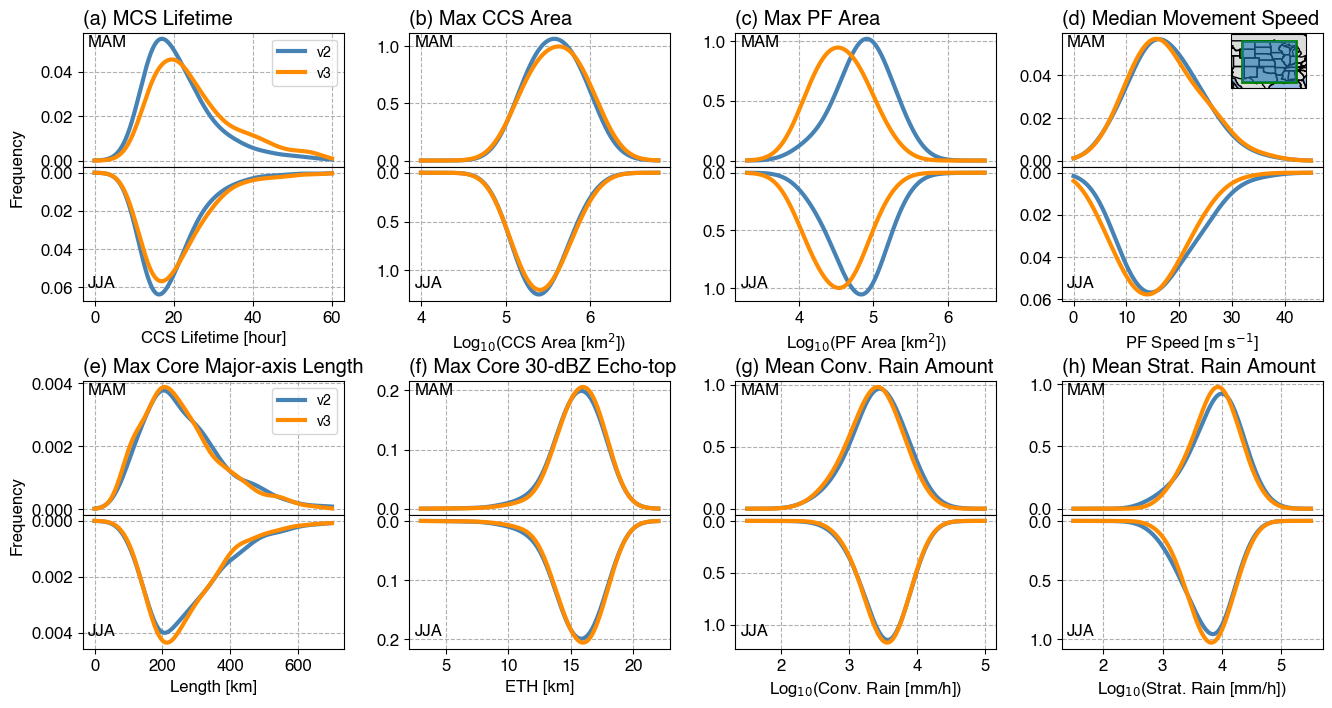

In [104]:
bins = [
    [lifetime_bins, ccsarea_bins, pfarea_bins, pfspeed_bins],
    [coremajoraxis_bins, coreETH30dbz_bins, convrain_bins, stratrain_bins],    
]
data_top = [
    [ccslifetime_dict_MAM, ccsarea_dict_MAM, pfarea_dict_MAM, pfspeed_dict_MAM], 
    [maxcoremaxis_dict_MAM, maxETH30dbz_dict_JJA, meanconvrain_dict_MAM, meanstratrain_dict_MAM, ],
]
data_bot = [
    [ccslifetime_dict_JJA, ccsarea_dict_JJA, pfarea_dict_JJA, pfspeed_dict_JJA], 
    [maxcoremaxis_dict_JJA, maxETH30dbz_dict_JJA, meanconvrain_dict_JJA, meanstratrain_dict_JJA, ],
]
titles = [
    ['(a) MCS Lifetime', '(b) Max CCS Area', '(c) Max PF Area', '(d) Median Movement Speed'],
    ['(e) Max Core Major-axis Length', '(f) Max Core 30-dBZ Echo-top', '(g) Mean Conv. Rain Amount', '(h) Mean Strat. Rain Amount'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(CCS Area [km$^2$])', 'Log$_{10}$(PF Area [km$^2$])', 'PF Speed [m s$^{-1}$]', ],
    ['Length [km]', 'ETH [km]', 'Log$_{10}$(Conv. Rain [mm/h])', 'Log$_{10}$(Strat. Rain [mm/h])'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
label_topbot = {'top':'MAM', 'bottom':'JJA'}
label_pos = {'top':{'x':0.02, 'y':0.9}, 'bottom':{'x':0.02, 'y':0.1}}
legend_loc = ['upper right', 'upper right']
legend_ncol = [1, 1]
map_panel = {'row': 0, 'col': 3, 'rowsub': 0, 'colsub': 0}
figname = f'{figdir}kde1d_mcs_MAM_JJA_2x4_{region}.png'
fig = plot_pdf_mirror_mxn(2, 4, 2, 1, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                          fontsize=12, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=map_panel,
                          legend_fontsize=10, legend_loc=legend_loc, legend_ncol=legend_ncol, label_topbot=label_topbot, label_pos=label_pos, 
                          figsize=[16,8])

## Function to plot 1D KDE on (m x n) panels

In [105]:
def plot_pdf_mxn(nrow, ncol, bins, data_arr, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                fontsize=12, legend_fontsize=11, legend_loc='best', figsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.35)

    lw = 3
    lcolors = {
        'v2':'steelblue', 
        'v3': 'darkorange',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = plt.subplot(outer_grid[row,col])
            ax.plot(bins[row][col], data_arr[row][col]['v2'], lcolors['v2'], lw=lw, label=legends['v2'])
            ax.plot(bins[row][col], data_arr[row][col]['v3'], lcolors['v3'], lw=lw, label=legends['v3'])
            # Labels
            if (col == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row][col])
            # if (col == 0):
            ax.set_ylabel(ylabels[row][col])
            # ax.set_xticks(xticks[col])
            # ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

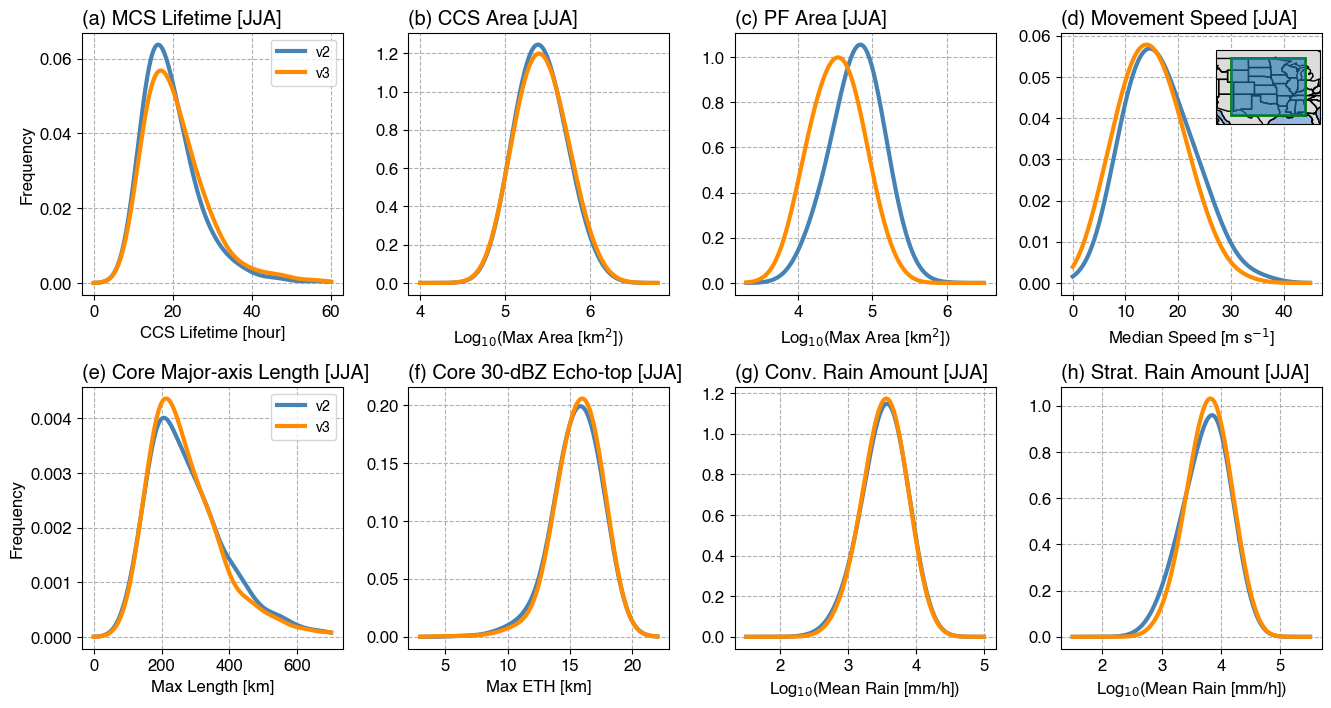

In [107]:
bins = [
    [lifetime_bins, ccsarea_bins, pfarea_bins, pfspeed_bins],
    [coremajoraxis_bins, coreETH30dbz_bins, convrain_bins, stratrain_bins],    
]
data_arr = [
    [ccslifetime_dict_JJA, ccsarea_dict_JJA, pfarea_dict_JJA, pfspeed_dict_JJA], 
    [maxcoremaxis_dict_JJA, maxETH30dbz_dict_JJA, meanconvrain_dict_JJA, meanstratrain_dict_JJA, ],
]
titles = [
    ['(a) MCS Lifetime [JJA]', '(b) CCS Area [JJA]', '(c) PF Area [JJA]', '(d) Movement Speed [JJA]'],
    ['(e) Core Major-axis Length [JJA]', '(f) Core 30-dBZ Echo-top [JJA]', '(g) Conv. Rain Amount [JJA]', '(h) Strat. Rain Amount [JJA]'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max Area [km$^2$])', 'Log$_{10}$(Max Area [km$^2$])', 'Median Speed [m s$^{-1}$]', ],
    ['Max Length [km]', 'Max ETH [km]', 'Log$_{10}$(Mean Rain [mm/h])', 'Log$_{10}$(Mean Rain [mm/h])'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
figname = f'{figdir}kde1d_mcs_JJA_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[16,8])

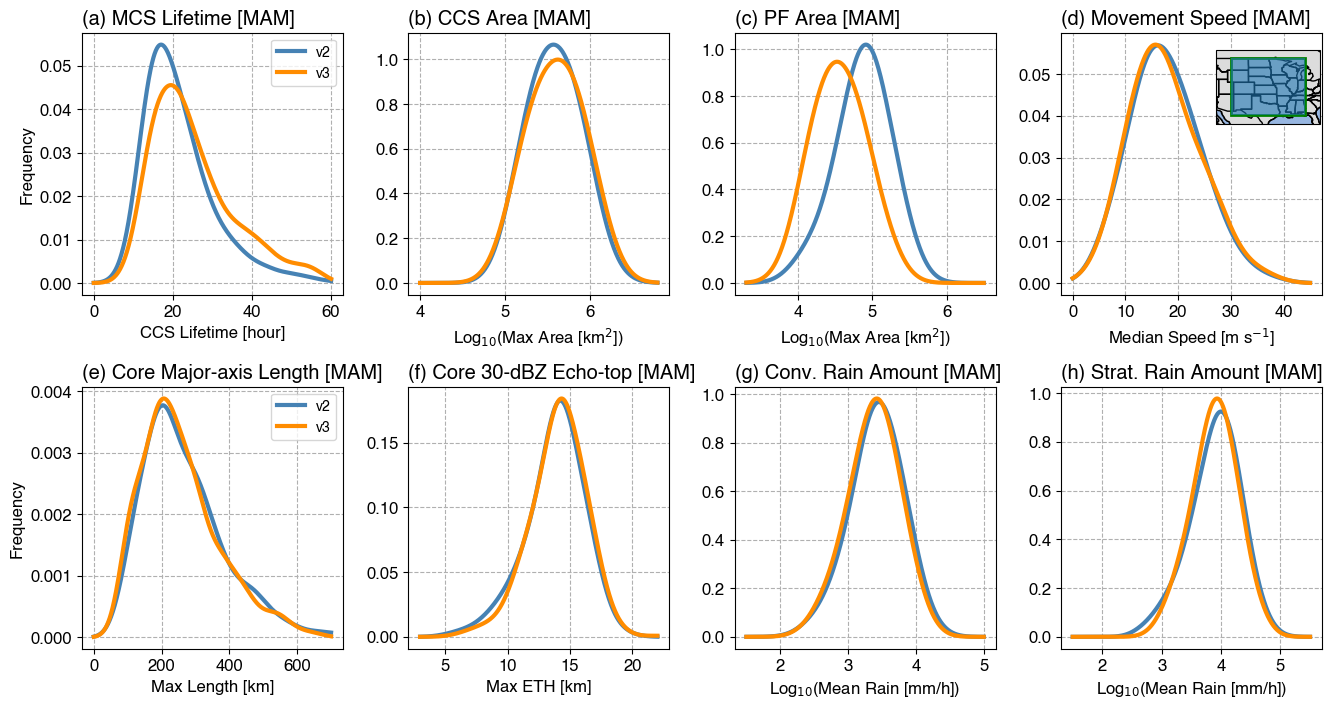

In [108]:
bins = [
    [lifetime_bins, ccsarea_bins, pfarea_bins, pfspeed_bins],
    [coremajoraxis_bins, coreETH30dbz_bins, convrain_bins, stratrain_bins],    
]
data_arr = [
    [ccslifetime_dict_MAM, ccsarea_dict_MAM, pfarea_dict_MAM, pfspeed_dict_MAM], 
    [maxcoremaxis_dict_MAM, maxETH30dbz_dict_MAM, meanconvrain_dict_MAM, meanstratrain_dict_MAM, ],
]
titles = [
    ['(a) MCS Lifetime [MAM]', '(b) CCS Area [MAM]', '(c) PF Area [MAM]', '(d) Movement Speed [MAM]'],
    ['(e) Core Major-axis Length [MAM]', '(f) Core 30-dBZ Echo-top [MAM]', '(g) Conv. Rain Amount [MAM]', '(h) Strat. Rain Amount [MAM]'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max Area [km$^2$])', 'Log$_{10}$(Max Area [km$^2$])', 'Median Speed [m s$^{-1}$]', ],
    ['Max Length [km]', 'Max ETH [km]', 'Log$_{10}$(Mean Rain [mm/h])', 'Log$_{10}$(Mean Rain [mm/h])'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
figname = f'{figdir}kde1d_mcs_MAM_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[16,8])

In [64]:
figdir

'/global/cfs/cdirs/m2637/zfeng/gridrad_v3/figures/'

## Function to composite track time-evolution by 1 condition

In [84]:
import warnings
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, quantiles):
    # Suppress RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Filter by one condition
        # in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]), drop=True)
        in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]))
        # Take lifetime-max, then count non-NaN to get number of samples
        max_in_var = in_var_cond.max(dim='times')
        nsamples = np.count_nonzero(~np.isnan(max_in_var))
        # nsamples = in_var_cond.sizes['tracks']
        out_var_mean = in_var_cond.mean(dim='tracks')
        out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

## Composite MCS time-evolution by CCS lifetime (for non-merge-split tracks only)
- Note the use of Dataset (ds_nms)

In [87]:
# Set lifetime range for composites
lifetime_range1 = [13, 16]
# lifetime_range2 = [18, 27]
lifetime_range2 = [22, 26]
quantiles = [0.25, 0.5, 0.75]

# Add mergers/splits to get total CCS area
ccsarea_v2 = ds_nms_v2.ccs_area.compute()
ccsarea_v3 = ds_nms_v3.ccs_area.compute()
# CCS lifetime
ccslifetime_v2 = (ds_nms_v2.length * time_res_v2).compute()
ccslifetime_v3 = (ds_nms_v3.track_duration * time_res_v3).compute()
# By season
ccslifetime_v2_MAM = ccslifetime_v2.where(start_season_v2 == 'MAM')
ccslifetime_v2_JJA = ccslifetime_v2.where(start_season_v2 == 'JJA')
ccslifetime_v3_MAM = ccslifetime_v3.where(start_season_v3 == 'MAM')
ccslifetime_v3_JJA = ccslifetime_v3.where(start_season_v3 == 'JJA')

ccsarea_v2_MAM = ccsarea_v2.where(start_season_v2 == 'MAM')
ccsarea_v2_JJA = ccsarea_v2.where(start_season_v2 == 'JJA')
ccsarea_v3_MAM = ccsarea_v3.where(start_season_v3 == 'MAM')
ccsarea_v3_JJA = ccsarea_v3.where(start_season_v3 == 'JJA')

# CCS Area
avg1_ccsarea_v2_MAM, qntl1_ccsarea_v2_MAM, ns1_v2_MAM = get_comp_tracks_by1cond(ccsarea_v2_MAM, ccslifetime_v2_MAM, lifetime_range1, quantiles)
avg2_ccsarea_v2_MAM, qntl2_ccsarea_v2_MAM, ns2_v2_MAM = get_comp_tracks_by1cond(ccsarea_v2_MAM, ccslifetime_v2_MAM, lifetime_range2, quantiles)
avg1_ccsarea_v2_JJA, qntl1_ccsarea_v2_JJA, ns1_v2_JJA = get_comp_tracks_by1cond(ccsarea_v2_JJA, ccslifetime_v2_JJA, lifetime_range1, quantiles)
avg2_ccsarea_v2_JJA, qntl2_ccsarea_v2_JJA, ns2_v2_JJA = get_comp_tracks_by1cond(ccsarea_v2_JJA, ccslifetime_v2_JJA, lifetime_range2, quantiles)

avg1_ccsarea_v3_MAM, qntl1_ccsarea_v3_MAM, ns1_v3_MAM = get_comp_tracks_by1cond(ccsarea_v3_MAM, ccslifetime_v3_MAM, lifetime_range1, quantiles)
avg2_ccsarea_v3_MAM, qntl2_ccsarea_v3_MAM, ns2_v3_MAM = get_comp_tracks_by1cond(ccsarea_v3_MAM, ccslifetime_v3_MAM, lifetime_range2, quantiles)
avg1_ccsarea_v3_JJA, qntl1_ccsarea_v3_JJA, ns1_v3_JJA = get_comp_tracks_by1cond(ccsarea_v3_JJA, ccslifetime_v3_JJA, lifetime_range1, quantiles)
avg2_ccsarea_v3_JJA, qntl2_ccsarea_v3_JJA, ns2_v3_JJA = get_comp_tracks_by1cond(ccsarea_v3_JJA, ccslifetime_v3_JJA, lifetime_range2, quantiles)
print(f'Sample number (range1) MAM: {ns1_v2_MAM} (v2), {ns1_v3_MAM} (v3)')
print(f'Sample number (range2) MAM: {ns2_v2_MAM} (v2), {ns2_v3_MAM} (v3)')
print(f'Sample number (range1) JJA: {ns1_v2_JJA} (v2), {ns1_v3_JJA} (v3)')
print(f'Sample number (range2) JJA: {ns2_v2_JJA} (v2), {ns2_v3_JJA} (v3)')

Sample number (range1) MAM: 177 (v2), 85 (v3)
Sample number (range2) MAM: 141 (v2), 96 (v3)
Sample number (range1) JJA: 460 (v2), 351 (v3)
Sample number (range2) JJA: 261 (v2), 259 (v3)


In [88]:
# Largest PF Area
pf_area_v2_MAM = ds_nms_v2.pf_area.isel(nmaxpf=0).where(start_season_v2 == 'MAM').compute()
pf_area_v2_JJA = ds_nms_v2.pf_area.isel(nmaxpf=0).where(start_season_v2 == 'JJA').compute()
pf_area_v3_MAM = ds_nms_v3.pf_area.isel(nmaxpf=0).where(start_season_v3 == 'MAM').compute()
pf_area_v3_JJA = ds_nms_v3.pf_area.isel(nmaxpf=0).where(start_season_v3 == 'JJA').compute()

avg1_pfarea_v2_MAM, qntl1_pfarea_v2_MAM, ns1_v2_MAM = get_comp_tracks_by1cond(pf_area_v2_MAM, ccslifetime_v2_MAM, lifetime_range1, quantiles)
avg2_pfarea_v2_MAM, qntl2_pfarea_v2_MAM, ns2_v2_MAM = get_comp_tracks_by1cond(pf_area_v2_MAM, ccslifetime_v2_MAM, lifetime_range2, quantiles)
avg1_pfarea_v2_JJA, qntl1_pfarea_v2_JJA, ns1_v2_JJA = get_comp_tracks_by1cond(pf_area_v2_JJA, ccslifetime_v2_JJA, lifetime_range1, quantiles)
avg2_pfarea_v2_JJA, qntl2_pfarea_v2_JJA, ns2_v2_JJA = get_comp_tracks_by1cond(pf_area_v2_JJA, ccslifetime_v2_JJA, lifetime_range2, quantiles)

avg1_pfarea_v3_MAM, qntl1_pfarea_v3_MAM, ns1_v3_MAM = get_comp_tracks_by1cond(pf_area_v3_MAM, ccslifetime_v3_MAM, lifetime_range1, quantiles)
avg2_pfarea_v3_MAM, qntl2_pfarea_v3_MAM, ns2_v3_MAM = get_comp_tracks_by1cond(pf_area_v3_MAM, ccslifetime_v3_MAM, lifetime_range2, quantiles)
avg1_pfarea_v3_JJA, qntl1_pfarea_v3_JJA, ns1_v3_JJA = get_comp_tracks_by1cond(pf_area_v3_JJA, ccslifetime_v3_JJA, lifetime_range1, quantiles)
avg2_pfarea_v3_JJA, qntl2_pfarea_v3_JJA, ns2_v3_JJA = get_comp_tracks_by1cond(pf_area_v3_JJA, ccslifetime_v3_JJA, lifetime_range2, quantiles)

In [89]:
# Core major axis length
coremajoraxis_v2_MAM = ds_nms_v2.pf_coremajoraxislength.max(dim=('nmaxcore')).where(start_season_v2 == 'MAM').compute()
coremajoraxis_v2_JJA = ds_nms_v2.pf_coremajoraxislength.max(dim=('nmaxcore')).where(start_season_v2 == 'JJA').compute()

coremajoraxis_v3_MAM = ds_nms_v3.pf_coremajoraxis.max(dim=('nmaxpf')).where(start_season_v3 == 'MAM').compute()
coremajoraxis_v3_JJA = ds_nms_v3.pf_coremajoraxis.max(dim=('nmaxpf')).where(start_season_v3 == 'JJA').compute()

avg1_coremajoraxis_v2_MAM, qntl1_coremajoraxis_v2_MAM, ns1_v2_MAM = get_comp_tracks_by1cond(coremajoraxis_v2_MAM, ccslifetime_v2_MAM, lifetime_range1, quantiles)
avg1_coremajoraxis_v2_JJA, qntl1_coremajoraxis_v2_JJA, ns1_v2_JJA = get_comp_tracks_by1cond(coremajoraxis_v2_JJA, ccslifetime_v2_JJA, lifetime_range1, quantiles)

avg1_coremajoraxis_v3_MAM, qntl1_coremajoraxis_v3_MAM, ns1_v3_MAM = get_comp_tracks_by1cond(coremajoraxis_v3_MAM, ccslifetime_v3_MAM, lifetime_range1, quantiles)
avg1_coremajoraxis_v3_JJA, qntl1_coremajoraxis_v3_JJA, ns1_v3_JJA = get_comp_tracks_by1cond(coremajoraxis_v3_JJA, ccslifetime_v3_JJA, lifetime_range1, quantiles)

avg2_coremajoraxis_v2_MAM, qntl2_coremajoraxis_v2_MAM, ns2_v2_MAM = get_comp_tracks_by1cond(coremajoraxis_v2_MAM, ccslifetime_v2_MAM, lifetime_range2, quantiles)
avg2_coremajoraxis_v2_JJA, qntl2_coremajoraxis_v2_JJA, ns2_v2_JJA = get_comp_tracks_by1cond(coremajoraxis_v2_JJA, ccslifetime_v2_JJA, lifetime_range2, quantiles)

avg2_coremajoraxis_v3_MAM, qntl2_coremajoraxis_v3_MAM, ns2_v3_MAM = get_comp_tracks_by1cond(coremajoraxis_v3_MAM, ccslifetime_v3_MAM, lifetime_range2, quantiles)
avg2_coremajoraxis_v3_JJA, qntl2_coremajoraxis_v3_JJA, ns2_v3_JJA = get_comp_tracks_by1cond(coremajoraxis_v3_JJA, ccslifetime_v3_JJA, lifetime_range2, quantiles)

In [90]:
# Core 30dbZ ETH
coreETH30dbz_v2_MAM = ds_nms_v2.pf_coremaxdbz30.max(dim=('nmaxcore')).where(start_season_v2 == 'MAM').compute()
coreETH30dbz_v2_JJA = ds_nms_v2.pf_coremaxdbz30.max(dim=('nmaxcore')).where(start_season_v2 == 'JJA').compute()

coreETH30dbz_v3_MAM = ds_nms_v3.pf_coremaxechotop30.max(dim=('nmaxpf')).where(start_season_v3 == 'MAM').compute()
coreETH30dbz_v3_JJA = ds_nms_v3.pf_coremaxechotop30.max(dim=('nmaxpf')).where(start_season_v3 == 'JJA').compute()

avg1_coreETH30dbz_v2_MAM, qntl1_coreETH30dbz_v2_MAM, ns1_v2_MAM = get_comp_tracks_by1cond(coreETH30dbz_v2_MAM, ccslifetime_v2_MAM, lifetime_range1, quantiles)
avg1_coreETH30dbz_v2_JJA, qntl1_coreETH30dbz_v2_JJA, ns1_v2_JJA = get_comp_tracks_by1cond(coreETH30dbz_v2_JJA, ccslifetime_v2_JJA, lifetime_range1, quantiles)

avg1_coreETH30dbz_v3_MAM, qntl1_coreETH30dbz_v3_MAM, ns1_v3_MAM = get_comp_tracks_by1cond(coreETH30dbz_v3_MAM, ccslifetime_v3_MAM, lifetime_range1, quantiles)
avg1_coreETH30dbz_v3_JJA, qntl1_coreETH30dbz_v3_JJA, ns1_v3_JJA = get_comp_tracks_by1cond(coreETH30dbz_v3_JJA, ccslifetime_v3_JJA, lifetime_range1, quantiles)

avg2_coreETH30dbz_v2_MAM, qntl2_coreETH30dbz_v2_MAM, ns2_v2_MAM = get_comp_tracks_by1cond(coreETH30dbz_v2_MAM, ccslifetime_v2_MAM, lifetime_range2, quantiles)
avg2_coreETH30dbz_v2_JJA, qntl2_coreETH30dbz_v2_JJA, ns2_v2_JJA = get_comp_tracks_by1cond(coreETH30dbz_v2_JJA, ccslifetime_v2_JJA, lifetime_range2, quantiles)

avg2_coreETH30dbz_v3_MAM, qntl2_coreETH30dbz_v3_MAM, ns2_v3_MAM = get_comp_tracks_by1cond(coreETH30dbz_v3_MAM, ccslifetime_v3_MAM, lifetime_range2, quantiles)
avg2_coreETH30dbz_v3_JJA, qntl2_coreETH30dbz_v3_JJA, ns2_v3_JJA = get_comp_tracks_by1cond(coreETH30dbz_v3_JJA, ccslifetime_v3_JJA, lifetime_range2, quantiles)

In [91]:
# Convective rain
convrain_v2_MAM = ds_nms_v2.pf_ccvolrate.where(start_season_v2 == 'MAM').compute()
convrain_v2_JJA = ds_nms_v2.pf_ccvolrate.where(start_season_v2 == 'JJA').compute()

convrain_v3_MAM = ds_nms_v3.conv_rain.where(start_season_v3 == 'MAM').compute()
convrain_v3_JJA = ds_nms_v3.conv_rain.where(start_season_v3 == 'JJA').compute()

avg1_convrain_v2_MAM, qntl1_convrain_v2_MAM, ns1_v2_MAM = get_comp_tracks_by1cond(convrain_v2_MAM, ccslifetime_v2_MAM, lifetime_range1, quantiles)
avg1_convrain_v2_JJA, qntl1_convrain_v2_JJA, ns1_v2_JJA = get_comp_tracks_by1cond(convrain_v2_JJA, ccslifetime_v2_JJA, lifetime_range1, quantiles)

avg1_convrain_v3_MAM, qntl1_convrain_v3_MAM, ns1_v3_MAM = get_comp_tracks_by1cond(convrain_v3_MAM, ccslifetime_v3_MAM, lifetime_range1, quantiles)
avg1_convrain_v3_JJA, qntl1_convrain_v3_JJA, ns1_v3_JJA = get_comp_tracks_by1cond(convrain_v3_JJA, ccslifetime_v3_JJA, lifetime_range1, quantiles)

avg2_convrain_v2_MAM, qntl2_convrain_v2_MAM, ns2_v2_MAM = get_comp_tracks_by1cond(convrain_v2_MAM, ccslifetime_v2_MAM, lifetime_range2, quantiles)
avg2_convrain_v2_JJA, qntl2_convrain_v2_JJA, ns2_v2_JJA = get_comp_tracks_by1cond(convrain_v2_JJA, ccslifetime_v2_JJA, lifetime_range2, quantiles)

avg2_convrain_v3_MAM, qntl2_convrain_v3_MAM, ns2_v3_MAM = get_comp_tracks_by1cond(convrain_v3_MAM, ccslifetime_v3_MAM, lifetime_range2, quantiles)
avg2_convrain_v3_JJA, qntl2_convrain_v3_JJA, ns2_v3_JJA = get_comp_tracks_by1cond(convrain_v3_JJA, ccslifetime_v3_JJA, lifetime_range2, quantiles)

In [92]:
# Stratiform rain
stratrain_v2_MAM = ds_nms_v2.pf_sfvolrate.where(start_season_v2 == 'MAM').compute()
stratrain_v2_JJA = ds_nms_v2.pf_sfvolrate.where(start_season_v2 == 'JJA').compute()

stratrain_v3_MAM = ds_nms_v3.strat_rain.where(start_season_v3 == 'MAM').compute()
stratrain_v3_JJA = ds_nms_v3.strat_rain.where(start_season_v3 == 'JJA').compute()

avg1_stratrain_v2_MAM, qntl1_stratrain_v2_MAM, ns1_v2_MAM = get_comp_tracks_by1cond(stratrain_v2_MAM, ccslifetime_v2_MAM, lifetime_range1, quantiles)
avg1_stratrain_v2_JJA, qntl1_stratrain_v2_JJA, ns1_v2_JJA = get_comp_tracks_by1cond(stratrain_v2_JJA, ccslifetime_v2_JJA, lifetime_range1, quantiles)

avg1_stratrain_v3_MAM, qntl1_stratrain_v3_MAM, ns1_v3_MAM = get_comp_tracks_by1cond(stratrain_v3_MAM, ccslifetime_v3_MAM, lifetime_range1, quantiles)
avg1_stratrain_v3_JJA, qntl1_stratrain_v3_JJA, ns1_v3_JJA = get_comp_tracks_by1cond(stratrain_v3_JJA, ccslifetime_v3_JJA, lifetime_range1, quantiles)

avg2_stratrain_v2_MAM, qntl2_stratrain_v2_MAM, ns2_v2_MAM = get_comp_tracks_by1cond(stratrain_v2_MAM, ccslifetime_v2_MAM, lifetime_range2, quantiles)
avg2_stratrain_v2_JJA, qntl2_stratrain_v2_JJA, ns2_v2_JJA = get_comp_tracks_by1cond(stratrain_v2_JJA, ccslifetime_v2_JJA, lifetime_range2, quantiles)

avg2_stratrain_v3_MAM, qntl2_stratrain_v3_MAM, ns2_v3_MAM = get_comp_tracks_by1cond(stratrain_v3_MAM, ccslifetime_v3_MAM, lifetime_range2, quantiles)
avg2_stratrain_v3_JJA, qntl2_stratrain_v3_JJA, ns2_v3_JJA = get_comp_tracks_by1cond(stratrain_v3_JJA, ccslifetime_v3_JJA, lifetime_range2, quantiles)

## Function to plot composite track time-evolution variables

In [93]:
def plot_evolution_mxn(nrow, ncol, hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                        titles=None, xlabels=None, ylabels=None, xticks=None, xlims=None, ylims=None, legends=None, 
                        map_extent=None, lon_bounds=None, lat_bounds=None, inset_param=None, figname=None, figsize=None,
                        fontsize=None, legend_fontsize=None, legend_loc='best'):
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    colors = {'v2':'steelblue', 'v3':'darkorange'}
    # Setup figure
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.35)
    # Loop over row and column
    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = plt.subplot(outer_grid[row,col])
            ax.plot(hours_obs[col], dataavg_obs[row][col], colors['v2'], lw=3, label=legends[col]['v2'])
            ax.plot(hours_m1[col], dataavg_m1[row][col], colors['v3'], lw=3, label=legends[col]['v3'])
            ax.fill_between(hours_obs[col], dataqntl_obs[row][col][0], dataqntl_obs[row][col][1], facecolor=colors['v2'],  alpha=0.3)
            ax.fill_between(hours_m1[col], dataqntl_m1[row][col][0], dataqntl_m1[row][col][1], facecolor=colors['v3'],  alpha=0.3)
            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == 0):               
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [94]:
lon_bounds, lat_bounds, region

([-110, -85], [30, 49], 'USA')

In [95]:
ns1_v2_MAM, ns2_v2_MAM

(177, 141)

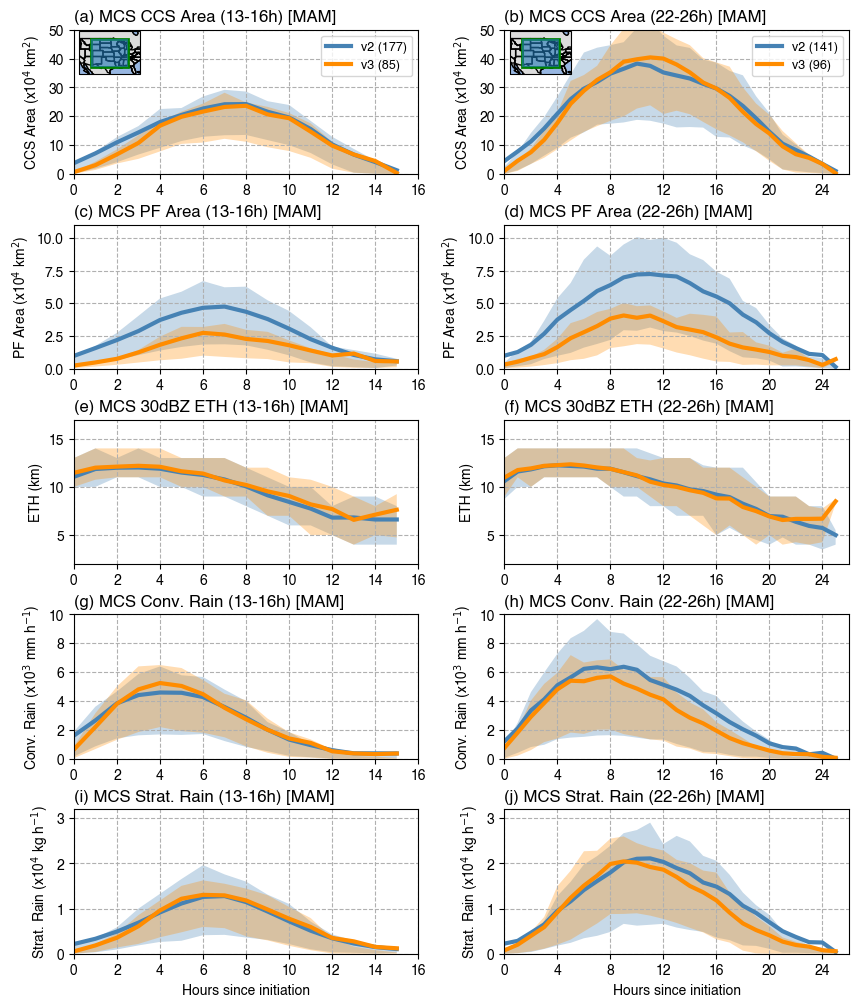

In [96]:
hours_v2 = [avg1_ccsarea_v2_MAM.times * time_res_v2, avg2_ccsarea_v2_MAM.times * time_res_v2]
hours_v3 = [avg1_ccsarea_v3_MAM.times * time_res_v3, avg2_ccsarea_v3_MAM.times * time_res_v3]
dataavg_v2 = [[avg1_ccsarea_v2_MAM/1e4, avg2_ccsarea_v2_MAM/1e4],
            [avg1_pfarea_v2_MAM/1e4, avg2_pfarea_v2_MAM/1e4], 
            [avg1_coreETH30dbz_v2_MAM, avg2_coreETH30dbz_v2_MAM],
            [avg1_convrain_v2_MAM/1e3, avg2_convrain_v2_MAM/1e3],
            [avg1_stratrain_v2_MAM/1e4, avg2_stratrain_v2_MAM/1e4]]
dataavg_v3 = [[avg1_ccsarea_v3_MAM/1e4, avg2_ccsarea_v3_MAM/1e4],
            [avg1_pfarea_v3_MAM/1e4, avg2_pfarea_v3_MAM/1e4], 
            [avg1_coreETH30dbz_v3_MAM, avg2_coreETH30dbz_v3_MAM],
            [avg1_convrain_v3_MAM/1e3, avg2_convrain_v3_MAM/1e3],
            [avg1_stratrain_v3_MAM/1e4, avg2_stratrain_v3_MAM/1e4]]
dataqntl_v2 = [[(qntl1_ccsarea_v2_MAM.sel(quantile=0.25)/1e4,qntl1_ccsarea_v2_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_v2_MAM.sel(quantile=0.25)/1e4,qntl2_ccsarea_v2_MAM.sel(quantile=0.75)/1e4)],
                [(qntl1_pfarea_v2_MAM.sel(quantile=0.25)/1e4,qntl1_pfarea_v2_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_pfarea_v2_MAM.sel(quantile=0.25)/1e4,qntl2_pfarea_v2_MAM.sel(quantile=0.75)/1e4)],
                [(qntl1_coreETH30dbz_v2_MAM.sel(quantile=0.25),qntl1_coreETH30dbz_v2_MAM.sel(quantile=0.75)), 
                 (qntl2_coreETH30dbz_v2_MAM.sel(quantile=0.25),qntl2_coreETH30dbz_v2_MAM.sel(quantile=0.75))],
                [(qntl1_convrain_v2_MAM.sel(quantile=0.25)/1e3,qntl1_convrain_v2_MAM.sel(quantile=0.75)/1e3), 
                 (qntl2_convrain_v2_MAM.sel(quantile=0.25)/1e3,qntl2_convrain_v2_MAM.sel(quantile=0.75)/1e3)],
                [(qntl1_stratrain_v2_MAM.sel(quantile=0.25)/1e4,qntl1_stratrain_v2_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_stratrain_v2_MAM.sel(quantile=0.25)/1e4,qntl2_stratrain_v2_MAM.sel(quantile=0.75)/1e4)],]
dataqntl_v3 = [[(qntl1_ccsarea_v3_MAM.sel(quantile=0.25)/1e4,qntl1_ccsarea_v3_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_v3_MAM.sel(quantile=0.25)/1e4,qntl2_ccsarea_v3_MAM.sel(quantile=0.75)/1e4)],
                [(qntl1_pfarea_v3_MAM.sel(quantile=0.25)/1e4,qntl1_pfarea_v3_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_pfarea_v3_MAM.sel(quantile=0.25)/1e4,qntl2_pfarea_v3_MAM.sel(quantile=0.75)/1e4)],
                [(qntl1_coreETH30dbz_v3_MAM.sel(quantile=0.25),qntl1_coreETH30dbz_v3_MAM.sel(quantile=0.75)), 
                 (qntl2_coreETH30dbz_v3_MAM.sel(quantile=0.25),qntl2_coreETH30dbz_v3_MAM.sel(quantile=0.75))],
                [(qntl1_convrain_v3_MAM.sel(quantile=0.25)/1e3,qntl1_convrain_v3_MAM.sel(quantile=0.75)/1e3), 
                 (qntl2_convrain_v3_MAM.sel(quantile=0.25)/1e3,qntl2_convrain_v3_MAM.sel(quantile=0.75)/1e3)],
                [(qntl1_stratrain_v3_MAM.sel(quantile=0.25)/1e4,qntl1_stratrain_v3_MAM.sel(quantile=0.75)/1e4), 
                 (qntl2_stratrain_v3_MAM.sel(quantile=0.25)/1e4,qntl2_stratrain_v3_MAM.sel(quantile=0.75)/1e4)],]
ns_v2 = [ns1_v2_MAM, ns2_v2_MAM]
ns_v3 = [ns1_v3_MAM, ns2_v3_MAM]
titles = []
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(c) MCS PF Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(d) MCS PF Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(e) MCS 30dBZ ETH ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(f) MCS 30dBZ ETH ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(g) MCS Conv. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(h) MCS Conv. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]'],
          [f'(i) MCS Strat. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [MAM]', f'(j) MCS Strat. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [MAM]']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'PF Area (x10$^{4}$ km$^2$)', 'ETH (km)', 'Conv. Rain (x10$^{3}$ mm h$^{-1}$)', 'Strat. Rain (x10$^{4}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,50), (0,11), (2,17), (0,10), (0,3.2)]
legends = [{'v2':f'v2 ({ns1_v2_MAM})', 'v3':f'v3 ({ns1_v3_MAM})'}, {'v2':f'v2 ({ns2_v2_MAM})', 'v3':f'v3 ({ns2_v3_MAM})'}]
figname = f'{figdir}mcs_composite_evolution_{region}_MAM.png'

bounds = [lon_bounds[0], lon_bounds[1]-0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [bounds[0]-8,bounds[1]+8,bounds[2]-5,bounds[3]+5]
inset_param = {'width':'20%', 'height':'30%', 'loc':'upper left', 'borderpad':0.1}

fig = plot_evolution_mxn(5, 2, hours_v2, hours_v3, dataavg_v2, dataqntl_v2, dataavg_v3, dataqntl_v3, ns_v2, ns_v3,  
                          titles=titles, xlabels=xlabels, ylabels=ylabels, xticks=xticks, xlims=xlims, ylims=ylims, legends=legends, 
                          map_extent=map_extent, lon_bounds=lon_bounds, lat_bounds=lat_bounds, inset_param=inset_param, figname=figname, figsize=[10,12],
                          fontsize=10, legend_fontsize=9, legend_loc='upper right')

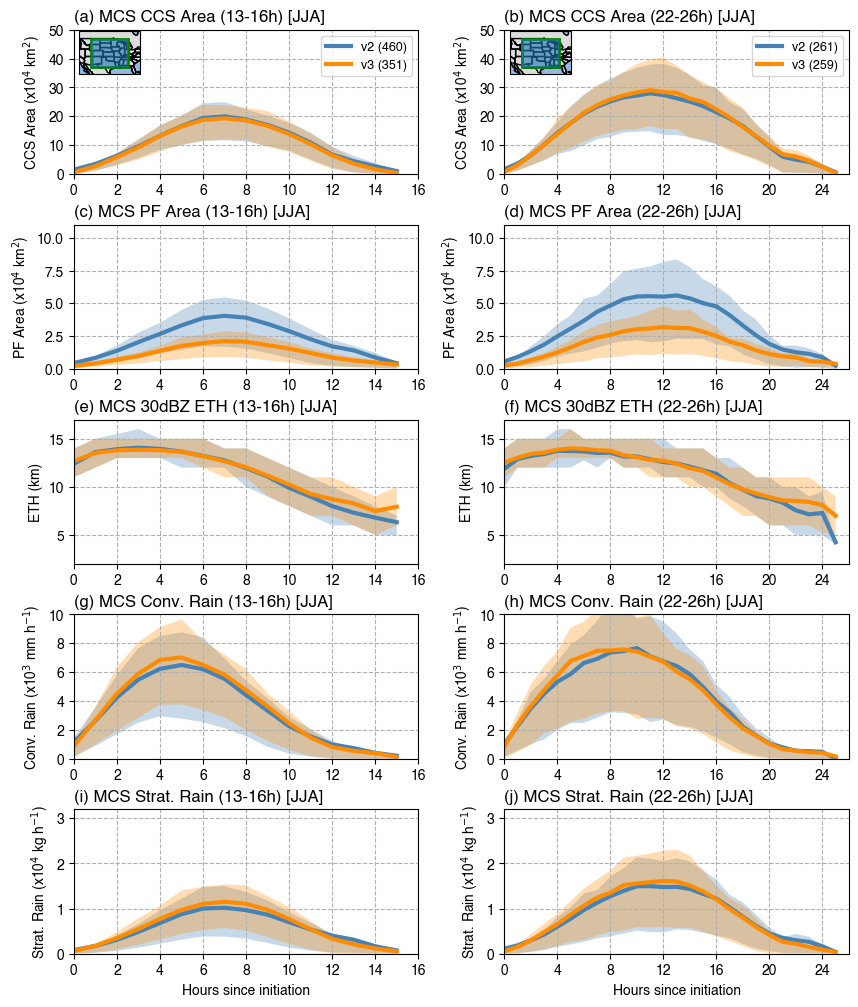

In [97]:
hours_v2 = [avg1_ccsarea_v2_JJA.times * time_res_v2, avg2_ccsarea_v2_JJA.times * time_res_v2]
hours_v3 = [avg1_ccsarea_v3_JJA.times * time_res_v3, avg2_ccsarea_v3_JJA.times * time_res_v3]
dataavg_v2 = [[avg1_ccsarea_v2_JJA/1e4, avg2_ccsarea_v2_JJA/1e4],
            [avg1_pfarea_v2_JJA/1e4, avg2_pfarea_v2_JJA/1e4], 
            [avg1_coreETH30dbz_v2_JJA, avg2_coreETH30dbz_v2_JJA],
            [avg1_convrain_v2_JJA/1e3, avg2_convrain_v2_JJA/1e3],
            [avg1_stratrain_v2_JJA/1e4, avg2_stratrain_v2_JJA/1e4]]
dataavg_v3 = [[avg1_ccsarea_v3_JJA/1e4, avg2_ccsarea_v3_JJA/1e4],
            [avg1_pfarea_v3_JJA/1e4, avg2_pfarea_v3_JJA/1e4], 
            [avg1_coreETH30dbz_v3_JJA, avg2_coreETH30dbz_v3_JJA],
            [avg1_convrain_v3_JJA/1e3, avg2_convrain_v3_JJA/1e3],
            [avg1_stratrain_v3_JJA/1e4, avg2_stratrain_v3_JJA/1e4]]
dataqntl_v2 = [[(qntl1_ccsarea_v2_JJA.sel(quantile=0.25)/1e4,qntl1_ccsarea_v2_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_v2_JJA.sel(quantile=0.25)/1e4,qntl2_ccsarea_v2_JJA.sel(quantile=0.75)/1e4)],
                [(qntl1_pfarea_v2_JJA.sel(quantile=0.25)/1e4,qntl1_pfarea_v2_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_pfarea_v2_JJA.sel(quantile=0.25)/1e4,qntl2_pfarea_v2_JJA.sel(quantile=0.75)/1e4)],
                [(qntl1_coreETH30dbz_v2_JJA.sel(quantile=0.25),qntl1_coreETH30dbz_v2_JJA.sel(quantile=0.75)), 
                 (qntl2_coreETH30dbz_v2_JJA.sel(quantile=0.25),qntl2_coreETH30dbz_v2_JJA.sel(quantile=0.75))],
                [(qntl1_convrain_v2_JJA.sel(quantile=0.25)/1e3,qntl1_convrain_v2_JJA.sel(quantile=0.75)/1e3), 
                 (qntl2_convrain_v2_JJA.sel(quantile=0.25)/1e3,qntl2_convrain_v2_JJA.sel(quantile=0.75)/1e3)],
                [(qntl1_stratrain_v2_JJA.sel(quantile=0.25)/1e4,qntl1_stratrain_v2_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_stratrain_v2_JJA.sel(quantile=0.25)/1e4,qntl2_stratrain_v2_JJA.sel(quantile=0.75)/1e4)],]
dataqntl_v3 = [[(qntl1_ccsarea_v3_JJA.sel(quantile=0.25)/1e4,qntl1_ccsarea_v3_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_v3_JJA.sel(quantile=0.25)/1e4,qntl2_ccsarea_v3_JJA.sel(quantile=0.75)/1e4)],
                [(qntl1_pfarea_v3_JJA.sel(quantile=0.25)/1e4,qntl1_pfarea_v3_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_pfarea_v3_JJA.sel(quantile=0.25)/1e4,qntl2_pfarea_v3_JJA.sel(quantile=0.75)/1e4)],
                [(qntl1_coreETH30dbz_v3_JJA.sel(quantile=0.25),qntl1_coreETH30dbz_v3_JJA.sel(quantile=0.75)), 
                 (qntl2_coreETH30dbz_v3_JJA.sel(quantile=0.25),qntl2_coreETH30dbz_v3_JJA.sel(quantile=0.75))],
                [(qntl1_convrain_v3_JJA.sel(quantile=0.25)/1e3,qntl1_convrain_v3_JJA.sel(quantile=0.75)/1e3), 
                 (qntl2_convrain_v3_JJA.sel(quantile=0.25)/1e3,qntl2_convrain_v3_JJA.sel(quantile=0.75)/1e3)],
                [(qntl1_stratrain_v3_JJA.sel(quantile=0.25)/1e4,qntl1_stratrain_v3_JJA.sel(quantile=0.75)/1e4), 
                 (qntl2_stratrain_v3_JJA.sel(quantile=0.25)/1e4,qntl2_stratrain_v3_JJA.sel(quantile=0.75)/1e4)],]
ns_v2 = [ns1_v2_JJA, ns2_v2_JJA]
ns_v3 = [ns1_v3_JJA, ns2_v3_JJA]
titles = []
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(c) MCS PF Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(d) MCS PF Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(e) MCS 30dBZ ETH ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(f) MCS 30dBZ ETH ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(g) MCS Conv. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(h) MCS Conv. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]'],
          [f'(i) MCS Strat. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [JJA]', f'(j) MCS Strat. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [JJA]']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'PF Area (x10$^{4}$ km$^2$)', 'ETH (km)', 'Conv. Rain (x10$^{3}$ mm h$^{-1}$)', 'Strat. Rain (x10$^{4}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,50), (0,11), (2,17), (0,10), (0,3.2)]
legends = [{'v2':f'v2 ({ns1_v2_JJA})', 'v3':f'v3 ({ns1_v3_JJA})'}, {'v2':f'v2 ({ns2_v2_JJA})', 'v3':f'v3 ({ns2_v3_JJA})'}]
figname = f'{figdir}mcs_composite_evolution_{region}_JJA.png'

bounds = [lon_bounds[0], lon_bounds[1]-0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [bounds[0]-8,bounds[1]+8,bounds[2]-5,bounds[3]+5]
inset_param = {'width':'20%', 'height':'30%', 'loc':'upper left', 'borderpad':0.1}

fig = plot_evolution_mxn(5, 2, hours_v2, hours_v3, dataavg_v2, dataqntl_v2, dataavg_v3, dataqntl_v3, ns_v2, ns_v3,  
                          titles=titles, xlabels=xlabels, ylabels=ylabels, xticks=xticks, xlims=xlims, ylims=ylims, legends=legends, 
                          map_extent=map_extent, lon_bounds=lon_bounds, lat_bounds=lat_bounds, inset_param=inset_param, figname=figname, figsize=[10,12],
                          fontsize=10, legend_fontsize=9, legend_loc='upper right')

In [98]:
figdir

'/global/cfs/cdirs/m2637/zfeng/gridrad_v3/figures/'